<a href="https://colab.research.google.com/github/abdo-ghg/Kepler-Exoplanet-/blob/main/Kepler_Exoplanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kepler Exoplanet Classification and Modeling Notebook


## 🪐 Notebook Description

This Jupyter Notebook is part of the ExoML Platform, an AI-powered system designed to detect and classify potential exoplanets from NASA’s Kepler, K2, and TESS missions.
The notebook focuses on data preprocessing, exploratory data analysis, feature engineering, and model training to distinguish between confirmed exoplanets and false positives.

It allows for:

Visual exploration of astronomical datasets

Model selection and performance evaluation

Integration with a Flask backend to visualize accuracy, AUC, recall, and precision on the website

Top 5 feature selection for each dataset to enable real-time prediction through the web app

## 📦 Imports & Configurations
Import libraries and set global options.

In [1]:
import os, json, uuid, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, roc_curve)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer 
from sklearn.impute import IterativeImputer
import joblib
import datetime, uuid, os, json
import warnings
warnings.filterwarnings('ignore')
NOTEBOOK_DIR = os.getcwd()
BASE_MODEL_DIR = os.path.join('..','models','Kepler')
PLOTS_DIR = os.path.join('..','static','plots','Kepler')
RESULTS_DIR = os.path.join('..','results')
DATA_PATH = os.path.join('..','..','Data Sources','Kepler.csv')  # ../../Data Sources/Kepler.csv from Notebook dir

os.makedirs(BASE_MODEL_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

RANDOM_STATE = 42
pd.set_option('display.max_columns', 200)
sns.set(style='whitegrid')

## 📂 Data Loading


In [2]:
df = pd.read_csv("k2.csv")
print(df.shape)
df.head()


(4004, 129)


,rowid,pl_name,hostname,pl_letter,k2_name,epic_hostname,epic_candname,hd_name,hip_name,tic_id,gaia_id,default_flag,disposition,disp_refname,sy_snum,sy_pnum,sy_mnum,cb_flag,discoverymethod,disc_year,disc_refname,disc_pubdate,disc_locale,disc_facility,disc_telescope,disc_instrument,rv_flag,pul_flag,ptv_flag,tran_flag,ast_flag,obm_flag,micro_flag,etv_flag,ima_flag,dkin_flag,soltype,pl_controv_flag,pl_refname,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_masse,pl_massj,pl_msinie,pl_msinij,pl_cmasse,pl_cmassj,pl_bmasse,pl_bmassj,pl_bmassprov,pl_dens,pl_orbeccen,pl_insol,pl_eqt,pl_orbincl,pl_tranmid,pl_tsystemref,ttv_flag,pl_imppar,pl_trandep,pl_trandur,pl_ratdor,pl_ratror,pl_occdep,pl_orbtper,pl_orblper,pl_rvamp,pl_projobliq,pl_trueobliq,st_refname,st_spectype,st_teff,st_rad,st_mass,st_met,st_metratio,st_lum,st_logg,st_age,st_dens,st_vsin,st_rotp,st_radv,sy_refname,rastr,ra,decstr,dec,glat,glon,elat,elon,sy_pm,sy_pmra,sy_pmdec,sy_dist,sy_plx,sy_bmag,sy_vmag,sy_jmag,sy_hmag,sy_kmag,sy_umag,sy_gmag,sy_rmag,sy_imag,sy_zmag,sy_w1mag,sy_w2mag,sy_w3mag,sy_w4mag,sy_gaiamag,sy_icmag,sy_tmag,sy_kepmag,rowupdate,pl_pubdate,releasedate,pl_nnotes,k2_campaigns,k2_campaigns_num,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,1,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,Gaia DR2 58200934326315136,0,CONFIRMED,Espinoza et al. 2016,1,1,0,0,Transit,2016,<a refstr=ESPINOZA_ET_AL__2016 href=https://ui...,2016-10,Space,K2,0.95 m Kepler Telescope,Kepler CCD Array,1,0,0,1,0,0,0,0,0,0,Published Confirmed,0,<a refstr=MAYO_ET_AL__2018 href=https://ui.ads...,41.688644,NaN,2.355454,0.210139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.52554,2457068.529,NaN,0,NaN,NaN,NaN,54.721028,0.022586,NaN,NaN,NaN,NaN,NaN,NaN,<a refstr=MAYO_ET_AL__2018 href=https://ui.ads...,NaN,5703.00,0.956122,0.963861,-0.06,[Fe/H],NaN,4.38000,NaN,NaN,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,03h34m36.27s,53.651123,+20d35m56.47s,20.599021,-28.05348,166.79660,1.31208,56.28872,63.053943,36.5714,-51.3647,179.4610,5.54366,11.765,10.849,9.770001,9.432,9.368,NaN,NaN,NaN,NaN,NaN,9.310,9.344,9.332,8.976,10.8644,NaN,10.4021,11.040,4/25/2018,2018-03,2/15/2018,1,4,1.0,0,0,0,0,0,0
1,2,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,Gaia DR2 58200934326315136,0,CONFIRMED,Espinoza et al. 2016,1,1,0,0,Transit,2016,<a refstr=ESPINOZA_ET_AL__2016 href=https://ui...,2016-10,Space,K2,0.95 m Kepler Telescope,Kepler CCD Array,1,0,0,1,0,0,0,0,0,0,Published Confirmed,0,<a refstr=ESPINOZA_ET_AL__2016 href=https://ui...,41.685500,0.241,2.230000,0.198947,16.3000,0.051285,NaN,NaN,NaN,NaN,16.3000,0.051285,Mass,7.89,0.0,NaN,546.0,89.55000,2457151.902,BJD-TDB,0,NaN,NaN,NaN,55.800000,0.022040,NaN,NaN,NaN,3.1,NaN,NaN,<a refstr=ESPINOZA_ET_AL__2016 href=https://ui...,G,5766.00,0.928000,0.961000,-0.15,[Fe/H],-0.05552,4.50000,3.34,1.700000,3.3,NaN,-20.33638,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,03h34m36.27s,53.651123,+20d35m56.47s,20.599021,-28.05348,166.79660,1.31208,56.28872,63.053943,36.5714,-51.3647,179.4610,5.54366,11.765,10.849,9.770001,9.432,9.368,NaN,NaN,NaN,NaN,NaN,9.310,9.344,9.332,8.976,10.8644,NaN,10.4021,11.040,4/25/2018,2016-10,7/28/2016,1,4,1.0,0,0,0,0,0,0
2,3,BD+20 594 b,BD+20 594,b,K2-56 b,EPIC 210848071,EPIC 210848071.01,NaN,NaN,TIC 26123781,Gaia DR2 58200934326315136,1,CONFIRMED,Espinoza et al. 2016,1,1,0,0,Transit,2016,<a refstr=ESPINOZA_ET_AL__2016 href=https://ui...,2016-10,Space,K2,0.95 m Kepler Telescope,Kepler CCD Array,1,0,0,1,0,0,0,0,0,0,Published Confirmed,0,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,41.685500,NaN,2.578070,0.230000,22.2481,0.070000,NaN,NaN,NaN,NaN,22.2481,0.070000,Mass,NaN,0.0,NaN,NaN,89.55000,NaN,NaN,0,NaN,0.049,NaN,55.800000,NaN,NaN,NaN,NaN,3.1,NaN,NaN,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,NaN,5766.00,1.080000,1.670000,-0.15,[Fe/H],NaN,4.50000,NaN,1.890000,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,03h34m36.27s

## ⚙️ Feature Engineering
Create new features, transform data.

In [3]:
print("Available columns in k2.csv:")
print(df.columns.tolist())
print(f"\nTotal columns: {len(df.columns)}")

selected_columns = [
    # --- Physical Parameters ---
    "pl_rade",          # Planet Radius (Earth radii)
    "pl_radj",          # Planet Radius (Jupiter radii)
    "pl_bmasse",        # Planet Mass (Earth mass)
    "pl_bmassj",        # Planet Mass (Jupiter mass)
    "pl_dens",          # Planet Density
    
    # --- Orbital Parameters ---
    "pl_orbper",        # Orbital Period (days)
    "pl_orbsmax",       # Semi-major Axis (AU)
    "pl_orbeccen",      # Eccentricity
    "pl_orbincl",       # Inclination (degrees)
    "pl_trandur",       # Transit Duration (hours)
    "pl_ratdor",        # Distance/Stellar Radius
    "pl_ratror",        # Planet/Stellar Radius Ratio
    
    # --- Thermal / Habitability ---
    "pl_eqt",           # Equilibrium Temperature (K)
    "pl_insol",         # Insolation Flux (Earth flux)
    
    # --- Stellar Properties ---
    "st_teff",          # Stellar Temperature (K)
    "st_logg",          # Stellar Surface Gravity
    "st_met",           # Stellar Metallicity
    "st_rad",           # Stellar Radius (Solar radii)
    "st_mass",          # Stellar Mass (Solar mass)
    "st_age",           # Stellar Age (Gyr)
    
    # --- Detection / Classification ---
    "disposition",       # Disposition (CONFIRMED, CANDIDATE, FALSE POSITIVE)
    "pl_trandep",       # Transit Depth (ppm)
    
    # --- Coordinates & brightness ---
    "ra",               # Right Ascension
    "dec",              # Declination
    "sy_kepmag"         # Kepler Magnitude
]

available_columns = [col for col in selected_columns if col in df.columns]
missing_columns = [col for col in selected_columns if col not in df.columns]

print(f"\n✅ Available columns: {len(available_columns)}")
print(f"❌ Missing columns: {missing_columns}")

df = df[available_columns]
print(f"\nDataFrame shape after selection: {df.shape}")

Available columns in k2.csv:
['rowid', 'pl_name', 'hostname', 'pl_letter', 'k2_name', 'epic_hostname', 'epic_candname', 'hd_name', 'hip_name', 'tic_id', 'gaia_id', 'default_flag', 'disposition', 'disp_refname', 'sy_snum', 'sy_pnum', 'sy_mnum', 'cb_flag', 'discoverymethod', 'disc_year', 'disc_refname', 'disc_pubdate', 'disc_locale', 'disc_facility', 'disc_telescope', 'disc_instrument', 'rv_flag', 'pul_flag', 'ptv_flag', 'tran_flag', 'ast_flag', 'obm_flag', 'micro_flag', 'etv_flag', 'ima_flag', 'dkin_flag', 'soltype', 'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_radj', 'pl_masse', 'pl_massj', 'pl_msinie', 'pl_msinij', 'pl_cmasse', 'pl_cmassj', 'pl_bmasse', 'pl_bmassj', 'pl_bmassprov', 'pl_dens', 'pl_orbeccen', 'pl_insol', 'pl_eqt', 'pl_orbincl', 'pl_tranmid', 'pl_tsystemref', 'ttv_flag', 'pl_imppar', 'pl_trandep', 'pl_trandur', 'pl_ratdor', 'pl_ratror', 'pl_occdep', 'pl_orbtper', 'pl_orblper', 'pl_rvamp', 'pl_projobliq', 'pl_trueobliq', 'st_refname', 'st_spe

In [4]:
# Rename columns for better readability (K2 dataset naming)
rename_dict = {
    # Physical
    "pl_rade": "planet_radius_earth",
    "pl_radj": "planet_radius_jupiter",
    "pl_bmasse": "planet_mass_earth",
    "pl_bmassj": "planet_mass_jupiter",
    "pl_dens": "planet_density",
    
    # Orbital
    "pl_orbper": "orbital_period_days",
    "pl_orbsmax": "semi_major_axis_AU",
    "pl_orbeccen": "eccentricity",
    "pl_orbincl": "inclination_deg",
    "pl_trandur": "transit_duration_hrs",
    "pl_ratdor": "scaled_distance_a_Rstar",
    "pl_ratror": "radius_ratio_Rp_Rstar",
    
    # Thermal
    "pl_eqt": "equilibrium_temp_K",
    "pl_insol": "insolation_flux_Earth",
    
    # Stellar
    "st_teff": "stellar_temp_K",
    "st_logg": "stellar_logg",
    "st_met": "stellar_metallicity",
    "st_rad": "stellar_radius_solar",
    "st_mass": "stellar_mass_solar",
    "st_age": "stellar_age_Gyr",
    
    # Detection
    "disposition": "final_disposition",
    "pl_trandep": "transit_depth_ppm",
    
    # Coordinates
    "ra": "RA_deg",
    "dec": "Dec_deg",
    "sy_kepmag": "kepler_mag"
}

# Rename columns that exist in the dataframe
cols_to_rename = {k: v for k, v in rename_dict.items() if k in df.columns}
df = df.rename(columns=cols_to_rename)

print("Columns after renaming:", df.columns.tolist())

# Create target variable based on disposition
if 'final_disposition' in df.columns:
    print("\nUnique disposition values:", df['final_disposition'].unique())
    print("Disposition value counts:")
    print(df['final_disposition'].value_counts())
    
    # Check what dispositions exist
    all_dispositions = df['final_disposition'].unique()
    
    # For K2 dataset: CONFIRMED vs CANDIDATE classification
    # If no FALSE POSITIVE exists, we classify CONFIRMED (1) vs CANDIDATE (0)
    if 'FALSE POSITIVE' in all_dispositions:
        # Standard classification: Exoplanet (CONFIRMED/CANDIDATE) vs FALSE POSITIVE
        valid_dispositions = ['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE']
        df = df[df['final_disposition'].isin(valid_dispositions)].copy()
        df['Target'] = (df['final_disposition'] != 'FALSE POSITIVE').astype(int)
        print("\n✅ Target: 1 = Exoplanet (CONFIRMED/CANDIDATE), 0 = FALSE POSITIVE")
    else:
        # Alternative: CONFIRMED vs CANDIDATE classification
        valid_dispositions = ['CONFIRMED', 'CANDIDATE']
        df = df[df['final_disposition'].isin(valid_dispositions)].copy()
        df['Target'] = (df['final_disposition'] == 'CONFIRMED').astype(int)
        print("\n✅ Target: 1 = CONFIRMED exoplanet, 0 = CANDIDATE (unconfirmed)")
    
    print(f'\nShape after filtering dispositions: {df.shape}')
    print(f'Target distribution:\n{df["Target"].value_counts()}')
else:
    print('⚠️ Warning: disposition column not found. Cannot create Target variable.')

df.head()

Columns after renaming: ['planet_radius_earth', 'planet_radius_jupiter', 'planet_mass_earth', 'planet_mass_jupiter', 'planet_density', 'orbital_period_days', 'semi_major_axis_AU', 'eccentricity', 'inclination_deg', 'transit_duration_hrs', 'scaled_distance_a_Rstar', 'radius_ratio_Rp_Rstar', 'equilibrium_temp_K', 'insolation_flux_Earth', 'stellar_temp_K', 'stellar_logg', 'stellar_metallicity', 'stellar_radius_solar', 'stellar_mass_solar', 'stellar_age_Gyr', 'final_disposition', 'transit_depth_ppm', 'RA_deg', 'Dec_deg', 'kepler_mag']

Unique disposition values: ['CONFIRMED' 'CANDIDATE' 'FALSE POSITIVE' 'REFUTED']
Disposition value counts:
final_disposition
CONFIRMED         2315
CANDIDATE         1374
FALSE POSITIVE     293
REFUTED             22
Name: count, dtype: int64

✅ Target: 1 = Exoplanet (CONFIRMED/CANDIDATE), 0 = FALSE POSITIVE

Shape after filtering dispositions: (3982, 26)
Target distribution:
Target
1    3689
0     293
Name: count, dtype: int64


,planet_radius_earth,planet_radius_jupiter,planet_mass_earth,planet_mass_jupiter,planet_density,orbital_period_days,semi_major_axis_AU,eccentricity,inclination_deg,transit_duration_hrs,scaled_distance_a_Rstar,radius_ratio_Rp_Rstar,equilibrium_temp_K,insolation_flux_Earth,stellar_temp_K,stellar_logg,stellar_metallicity,stellar_radius_solar,stellar_mass_solar,stellar_age_Gyr,final_disposition,transit_depth_ppm,RA_deg,Dec_deg,kepler_mag,Target
0,2.355454,0.210139,NaN,NaN,NaN,41.688644,NaN,NaN,89.52554,NaN,54.721028,0.022586,NaN,NaN,5703.00,4.38000,-0.06,0.956122,0.963861,NaN,CONFIRMED,NaN,53.651123,20.599021,11.040,1
1,2.230000,0.198947,16.3000,0.051285,7.89,41.685500,0.241,0.0,89.55000,NaN,55.800000,0.022040,546.0,NaN,5766.00,4.50000,-0.15,0.928000,0.961000,3.34,CONFIRMED,NaN,53.651123,20.599021,11.040,1
2,2.578070,0.230000,22.2481,0.070000,NaN,41.685500,NaN,0.0,89.55000,NaN,55.800000,NaN,NaN,NaN,5766.00,4.50000,-0.15,1.080000,1.670000,NaN,CONFIRMED,0.049,53.651123,20.599021,11.040,1
3,1.120000,0.099900,NaN,NaN,NaN,2.301830,NaN,NaN,NaN,1.9008,11.800000,0.014400,1054.0,NaN,4616.52,4.53679,-0.03,0.762602,0.730000,NaN,CANDIDATE,2.268,183.846245,-6.268329,11.363,1
4,1.312588,0.120000,NaN,NaN,NaN,2.302368,NaN,NaN,87.44384,NaN,12.619867,0.016925,NaN,NaN,4720.00,4.50000,-0.06,0.710995,NaN,NaN,CANDIDATE,NaN,183.846245,-6.268329,11.363,1


## 🧹 Data Cleaning
Handle missing values, duplicates, data types.

In [5]:
df.duplicated().sum()

np.int64(2)

In [6]:
df.isnull().sum()

planet_radius_earth         827
planet_radius_jupiter       827
planet_mass_earth          3547
planet_mass_jupiter        3547
planet_density             3623
orbital_period_days          44
semi_major_axis_AU         3163
eccentricity               3553
inclination_deg            2988
transit_duration_hrs       1219
scaled_distance_a_Rstar    1794
radius_ratio_Rp_Rstar       986
equilibrium_temp_K         3131
insolation_flux_Earth      3354
stellar_temp_K             1103
stellar_logg               1636
stellar_metallicity        2290
stellar_radius_solar        124
stellar_mass_solar         1887
stellar_age_Gyr            3665
final_disposition             0
transit_depth_ppm          1894
RA_deg                        0
Dec_deg                       0
kepler_mag                   15
Target                        0
dtype: int64

In [7]:

all_numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
all_categorical_cols = df.select_dtypes(include='object').columns.tolist()

numeric_cols_with_all_missing = [col for col in all_numeric_cols if df[col].isnull().all()]
print(f"Numeric columns with all missing values (will be skipped by IterativeImputer): {numeric_cols_with_all_missing}")

imputable_numeric_cols = [col for col in all_numeric_cols if col not in numeric_cols_with_all_missing]
print(f"Numeric columns to impute iteratively: {imputable_numeric_cols}")

if len(imputable_numeric_cols) > 0:
    df_numeric_imputable = df[imputable_numeric_cols].copy()
    imputer = IterativeImputer(random_state=42)
    df_imputed_values = imputer.fit_transform(df_numeric_imputable)
    df_imputed_part = pd.DataFrame(df_imputed_values, columns=imputable_numeric_cols, index=df.index)
    df[imputable_numeric_cols] = df_imputed_part[imputable_numeric_cols]
    print("Iterative imputation applied to numeric columns that are not all missing.")
    print("\nMissing values after numeric imputation (imputable numeric columns):")
    print(df[imputable_numeric_cols].isnull().sum().sum()) # Should be 0 if imputation was successful for these
else:
    print("No numeric columns found that require iterative imputation.")


print(f"\nCategorical columns identified: {all_categorical_cols}")

if len(all_categorical_cols) > 0:
    cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
    df[all_categorical_cols] = cat_imputer.fit_transform(df[all_categorical_cols])
    print("Simple imputation applied to categorical columns.")
    print("\nMissing values after categorical imputation:")
    print(df[all_categorical_cols].isnull().sum().sum()) # Should be 0 after imputation

else:
    print("No categorical columns found to impute.")

Numeric columns with all missing values (will be skipped by IterativeImputer): []
Numeric columns to impute iteratively: ['planet_radius_earth', 'planet_radius_jupiter', 'planet_mass_earth', 'planet_mass_jupiter', 'planet_density', 'orbital_period_days', 'semi_major_axis_AU', 'eccentricity', 'inclination_deg', 'transit_duration_hrs', 'scaled_distance_a_Rstar', 'radius_ratio_Rp_Rstar', 'equilibrium_temp_K', 'insolation_flux_Earth', 'stellar_temp_K', 'stellar_logg', 'stellar_metallicity', 'stellar_radius_solar', 'stellar_mass_solar', 'stellar_age_Gyr', 'transit_depth_ppm', 'RA_deg', 'Dec_deg', 'kepler_mag', 'Target']
Iterative imputation applied to numeric columns that are not all missing.

Missing values after numeric imputation (imputable numeric columns):
0

Categorical columns identified: ['final_disposition']
Simple imputation applied to categorical columns.

Missing values after categorical imputation:
0


In [8]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print("Numeric columns:", numeric_cols)
print("\nCategorical columns:", categorical_cols)

Numeric columns: ['planet_radius_earth', 'planet_radius_jupiter', 'planet_mass_earth', 'planet_mass_jupiter', 'planet_density', 'orbital_period_days', 'semi_major_axis_AU', 'eccentricity', 'inclination_deg', 'transit_duration_hrs', 'scaled_distance_a_Rstar', 'radius_ratio_Rp_Rstar', 'equilibrium_temp_K', 'insolation_flux_Earth', 'stellar_temp_K', 'stellar_logg', 'stellar_metallicity', 'stellar_radius_solar', 'stellar_mass_solar', 'stellar_age_Gyr', 'transit_depth_ppm', 'RA_deg', 'Dec_deg', 'kepler_mag', 'Target']

Categorical columns: ['final_disposition']


In [9]:
df.shape

(3982, 26)

In [10]:
df.nunique()

planet_radius_earth        2487
planet_radius_jupiter      2717
planet_mass_earth          3908
planet_mass_jupiter        3940
planet_density             3890
orbital_period_days        3849
semi_major_axis_AU         3834
eccentricity               3695
inclination_deg            3633
transit_duration_hrs       2975
scaled_distance_a_Rstar    3302
radius_ratio_Rp_Rstar      2786
equilibrium_temp_K         3807
insolation_flux_Earth      3919
stellar_temp_K             2757
stellar_logg               2647
stellar_metallicity        2751
stellar_radius_solar       1953
stellar_mass_solar         2656
stellar_age_Gyr            3784
final_disposition             3
transit_depth_ppm          3500
RA_deg                     1552
Dec_deg                    1552
kepler_mag                 1359
Target                        2
dtype: int64

In [11]:
# Drop columns that are not useful for modeling or have too many missing values
columns_to_drop = ['final_disposition']  # We already used this to create Target

# Also consider dropping columns with high missing percentage
missing_pct = df.isnull().sum() / len(df) * 100
high_missing_cols = missing_pct[missing_pct > 70].index.tolist()
print(f"Columns with >70% missing values: {high_missing_cols}")

columns_to_drop.extend(high_missing_cols)
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=existing_columns_to_drop, axis=1)
print(f"✅ Shape after dropping columns: {df.shape}")
print(f"Remaining columns: {df.columns.tolist()}")

Columns with >70% missing values: []
✅ Shape after dropping columns: (3982, 25)
Remaining columns: ['planet_radius_earth', 'planet_radius_jupiter', 'planet_mass_earth', 'planet_mass_jupiter', 'planet_density', 'orbital_period_days', 'semi_major_axis_AU', 'eccentricity', 'inclination_deg', 'transit_duration_hrs', 'scaled_distance_a_Rstar', 'radius_ratio_Rp_Rstar', 'equilibrium_temp_K', 'insolation_flux_Earth', 'stellar_temp_K', 'stellar_logg', 'stellar_metallicity', 'stellar_radius_solar', 'stellar_mass_solar', 'stellar_age_Gyr', 'transit_depth_ppm', 'RA_deg', 'Dec_deg', 'kepler_mag', 'Target']


## 🔍 Exploratory Data Analysis (EDA)
Summarize the dataset and visualize distributions.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3982 entries, 0 to 4003
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   planet_radius_earth      3982 non-null   float64
 1   planet_radius_jupiter    3982 non-null   float64
 2   planet_mass_earth        3982 non-null   float64
 3   planet_mass_jupiter      3982 non-null   float64
 4   planet_density           3982 non-null   float64
 5   orbital_period_days      3982 non-null   float64
 6   semi_major_axis_AU       3982 non-null   float64
 7   eccentricity             3982 non-null   float64
 8   inclination_deg          3982 non-null   float64
 9   transit_duration_hrs     3982 non-null   float64
 10  scaled_distance_a_Rstar  3982 non-null   float64
 11  radius_ratio_Rp_Rstar    3982 non-null   float64
 12  equilibrium_temp_K       3982 non-null   float64
 13  insolation_flux_Earth    3982 non-null   float64
 14  stellar_temp_K           3982

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
planet_radius_earth,3982.0,8.459773,26.791079,0.406400,2.030000,3.301050,8.479692,1080.000000
planet_radius_jupiter,3982.0,0.754547,2.393224,0.036257,0.181104,0.295298,0.754344,96.400000
planet_mass_earth,3982.0,130.169673,104.615783,0.290131,130.135554,130.159930,130.188655,4131.790000
planet_mass_jupiter,3982.0,0.409563,0.329157,0.000913,0.409438,0.409520,0.409620,13.000000
planet_density,3982.0,4.712416,14.939823,-294.728899,2.008013,3.978557,6.155337,231.481530
orbital_period_days,3982.0,40.456117,1339.039227,0.175660,2.875185,6.790253,14.302424,83830.000000
semi_major_axis_AU,3982.0,0.112280,1.018016,-3.895067,0.053125,0.081785,0.113860,63.162429
eccentricity,3982.0,0.082724,0.226077,-6.570739,0.051870,0.093891,0.135529,3.850612
inclination_deg,3982.0,87.279484,7.356441,12.250837,86.806381,87.583306,88.364481,498.690653
transit_duration_hrs,3982.0,3.735541,23.212061,-14.274194,2.118750,3.000000,3.888000,1451.704555


In [14]:
print('Columns:', df.columns.tolist())
print('\nMissing values per column:')
print(df.isnull().sum().sort_values(ascending=False).head(20))
print('\nTarget distribution:')
print(df['Target'].value_counts(normalize=True))

Columns: ['planet_radius_earth', 'planet_radius_jupiter', 'planet_mass_earth', 'planet_mass_jupiter', 'planet_density', 'orbital_period_days', 'semi_major_axis_AU', 'eccentricity', 'inclination_deg', 'transit_duration_hrs', 'scaled_distance_a_Rstar', 'radius_ratio_Rp_Rstar', 'equilibrium_temp_K', 'insolation_flux_Earth', 'stellar_temp_K', 'stellar_logg', 'stellar_metallicity', 'stellar_radius_solar', 'stellar_mass_solar', 'stellar_age_Gyr', 'transit_depth_ppm', 'RA_deg', 'Dec_deg', 'kepler_mag', 'Target']

Missing values per column:
planet_radius_earth        0
planet_radius_jupiter      0
planet_mass_earth          0
planet_mass_jupiter        0
planet_density             0
orbital_period_days        0
semi_major_axis_AU         0
eccentricity               0
inclination_deg            0
transit_duration_hrs       0
scaled_distance_a_Rstar    0
radius_ratio_Rp_Rstar      0
equilibrium_temp_K         0
insolation_flux_Earth      0
stellar_temp_K             0
stellar_logg              

## 📈 Data Visualization
Deeper insights with plots.

Found 54 pairs with |correlation| >= 0.5


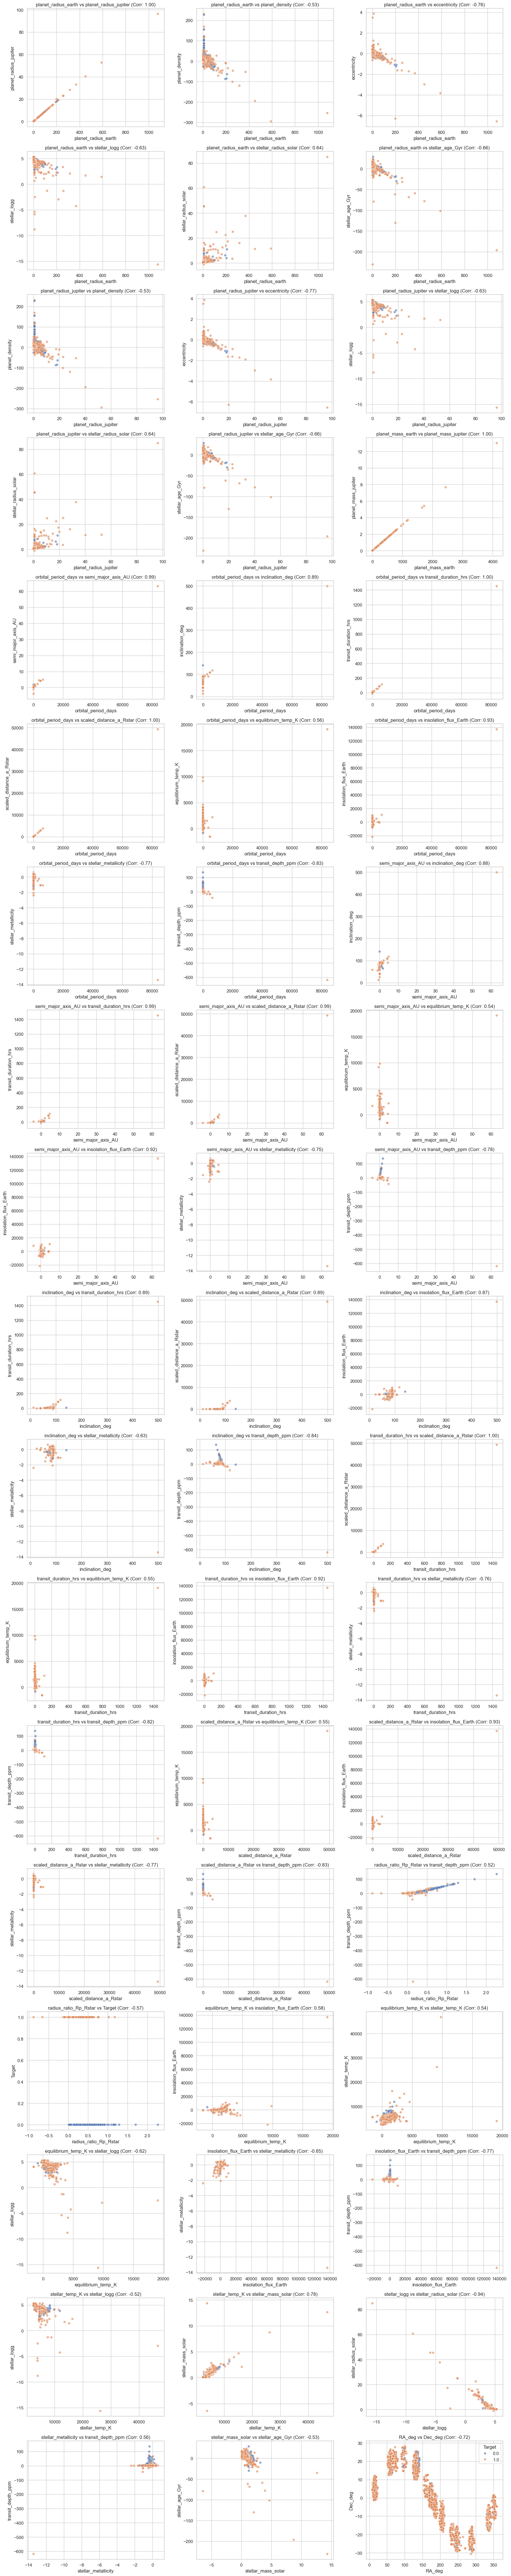

In [15]:
numeric_df = df.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()

# Find pairs of columns with correlation >= 0.5 or <= -0.5 (excluding self-correlation)
high_corr_pairs = []
# Use abs() for correlation to include strong negative correlations
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) >= 0.5:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs.append((col1, col2, correlation_matrix.iloc[i, j]))

print(f"Found {len(high_corr_pairs)} pairs with |correlation| >= 0.5")

# Determine the number of rows and columns for subplots
n_pairs = len(high_corr_pairs)
n_cols = 3  # You can adjust the number of columns as needed
n_rows = (n_pairs + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 6, n_rows * 5)) # Adjust figure size dynamically

for i, (col1, col2, corr_value) in enumerate(high_corr_pairs):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(data=df, x=col1, y=col2, hue='Target', alpha=0.6)
    plt.title(f'{col1} vs {col2} (Corr: {corr_value:.2f})')
    plt.xlabel(col1)
    plt.ylabel(col2)
    # Optional: Remove legend from individual subplots if there are many to avoid clutter
    if i < n_pairs - 1: # Keep legend only for the last plot or remove entirely
        plt.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

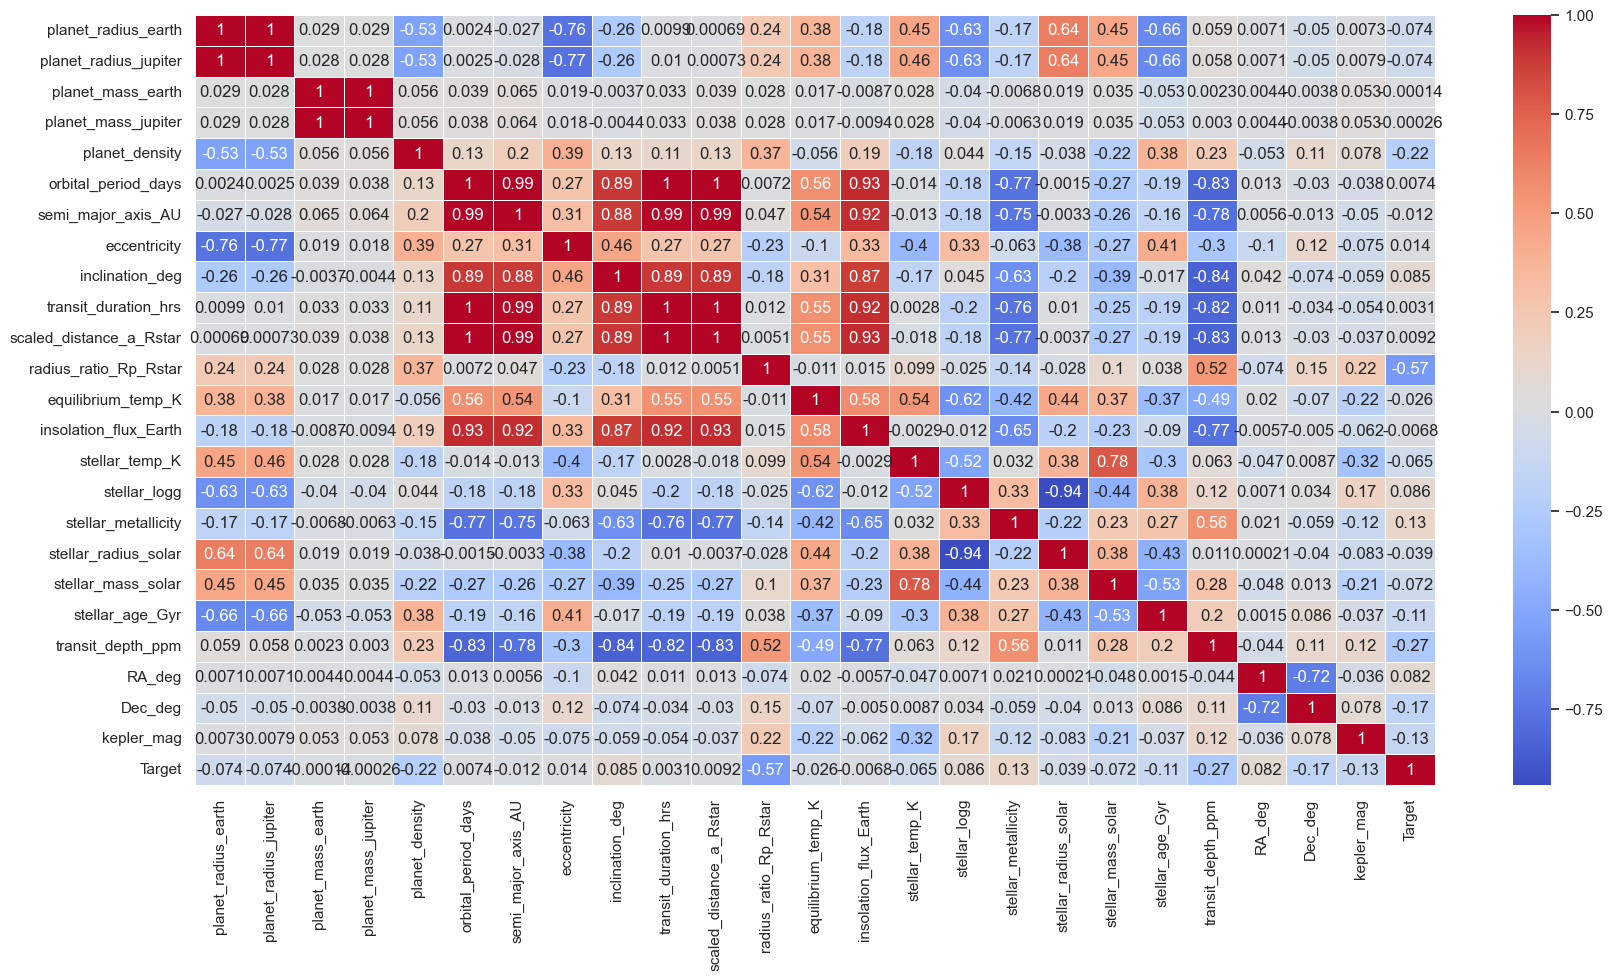

In [16]:
numeric_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(20,10))
sns.heatmap(numeric_df.corr(),annot=True,cmap='coolwarm',linewidths=0.5)
plt.show()

dispsition score (koi_scroe) is a the importantest feature

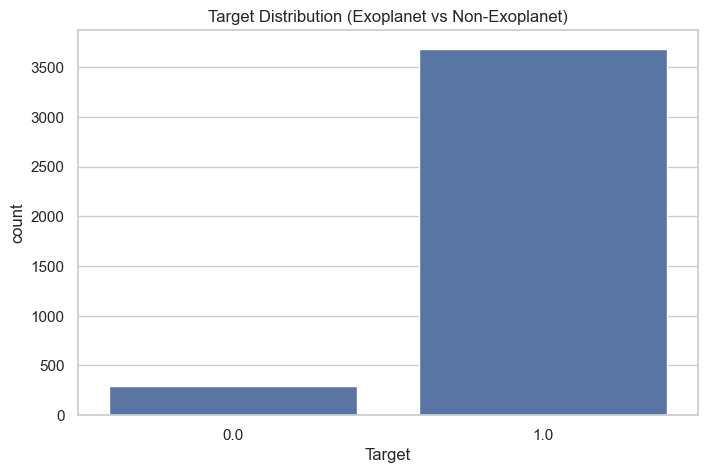

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(x=df['Target'])
plt.title("Target Distribution (Exoplanet vs Non-Exoplanet)")
plt.show()

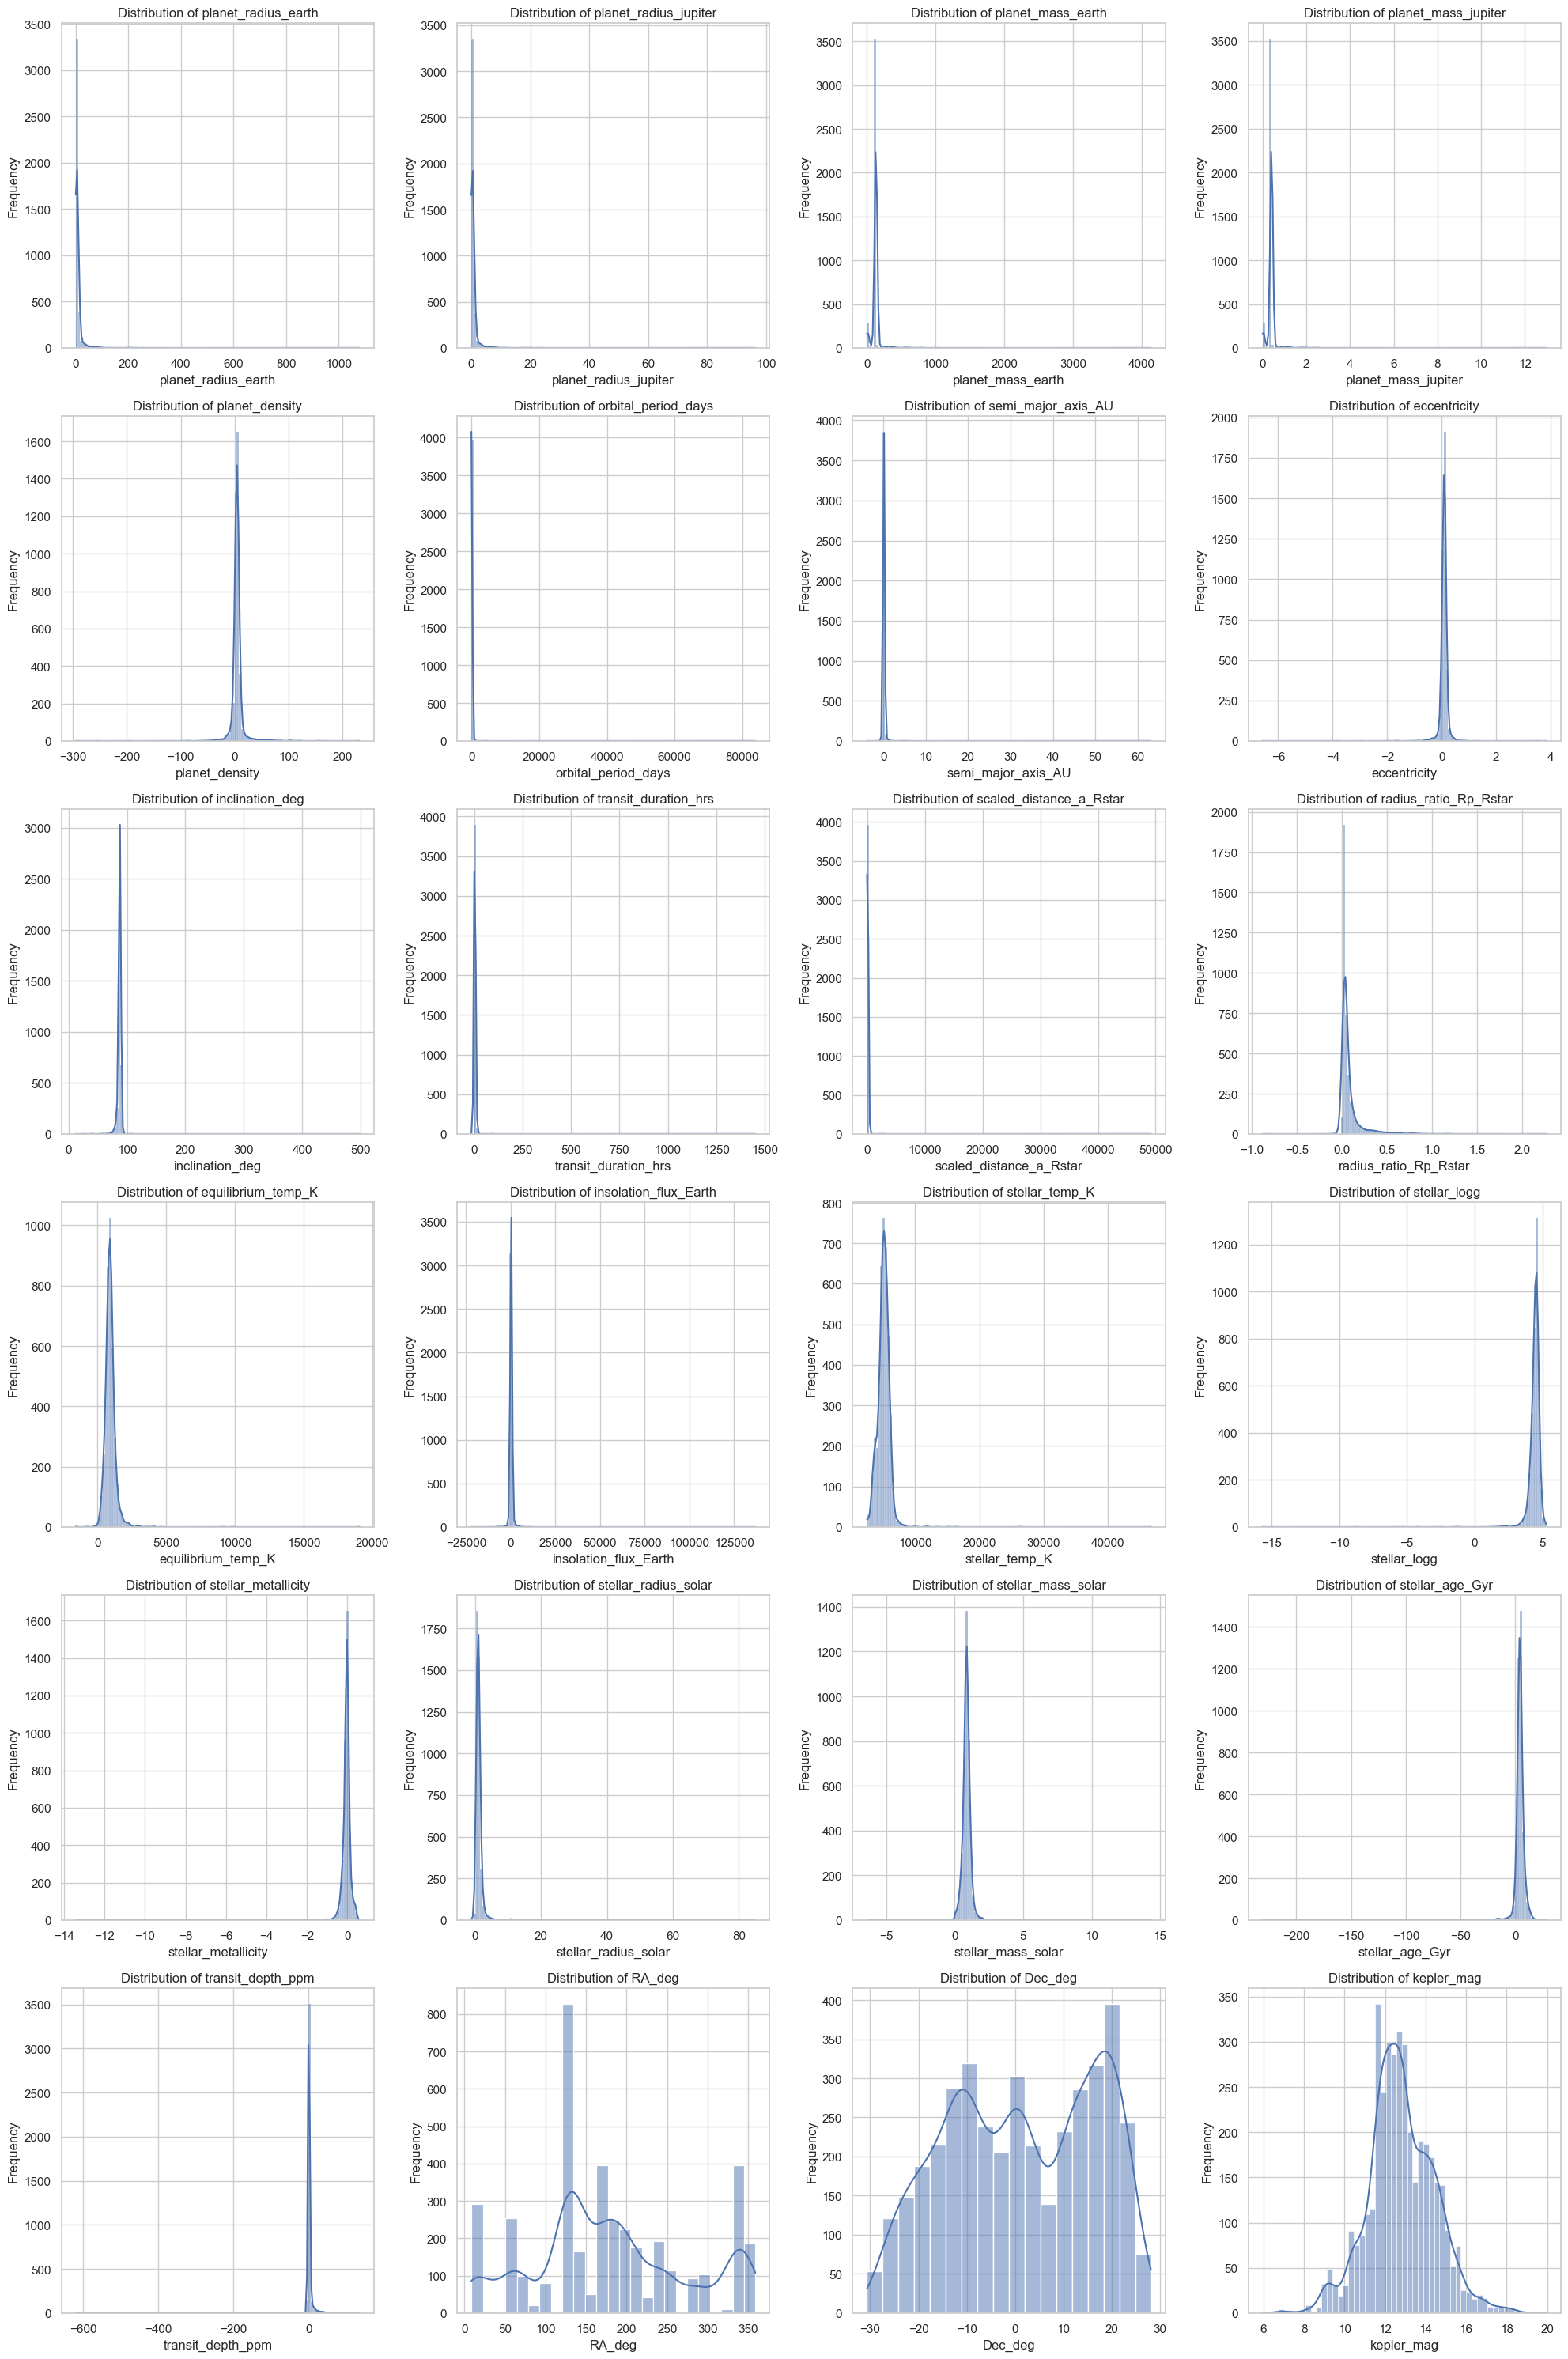

In [18]:

cols_for_hist = [col for col in numeric_cols if df[col].nunique() > 4]

n_cols = 4
n_rows = (len(cols_for_hist) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 5))

for i, col in enumerate(cols_for_hist):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Outliers

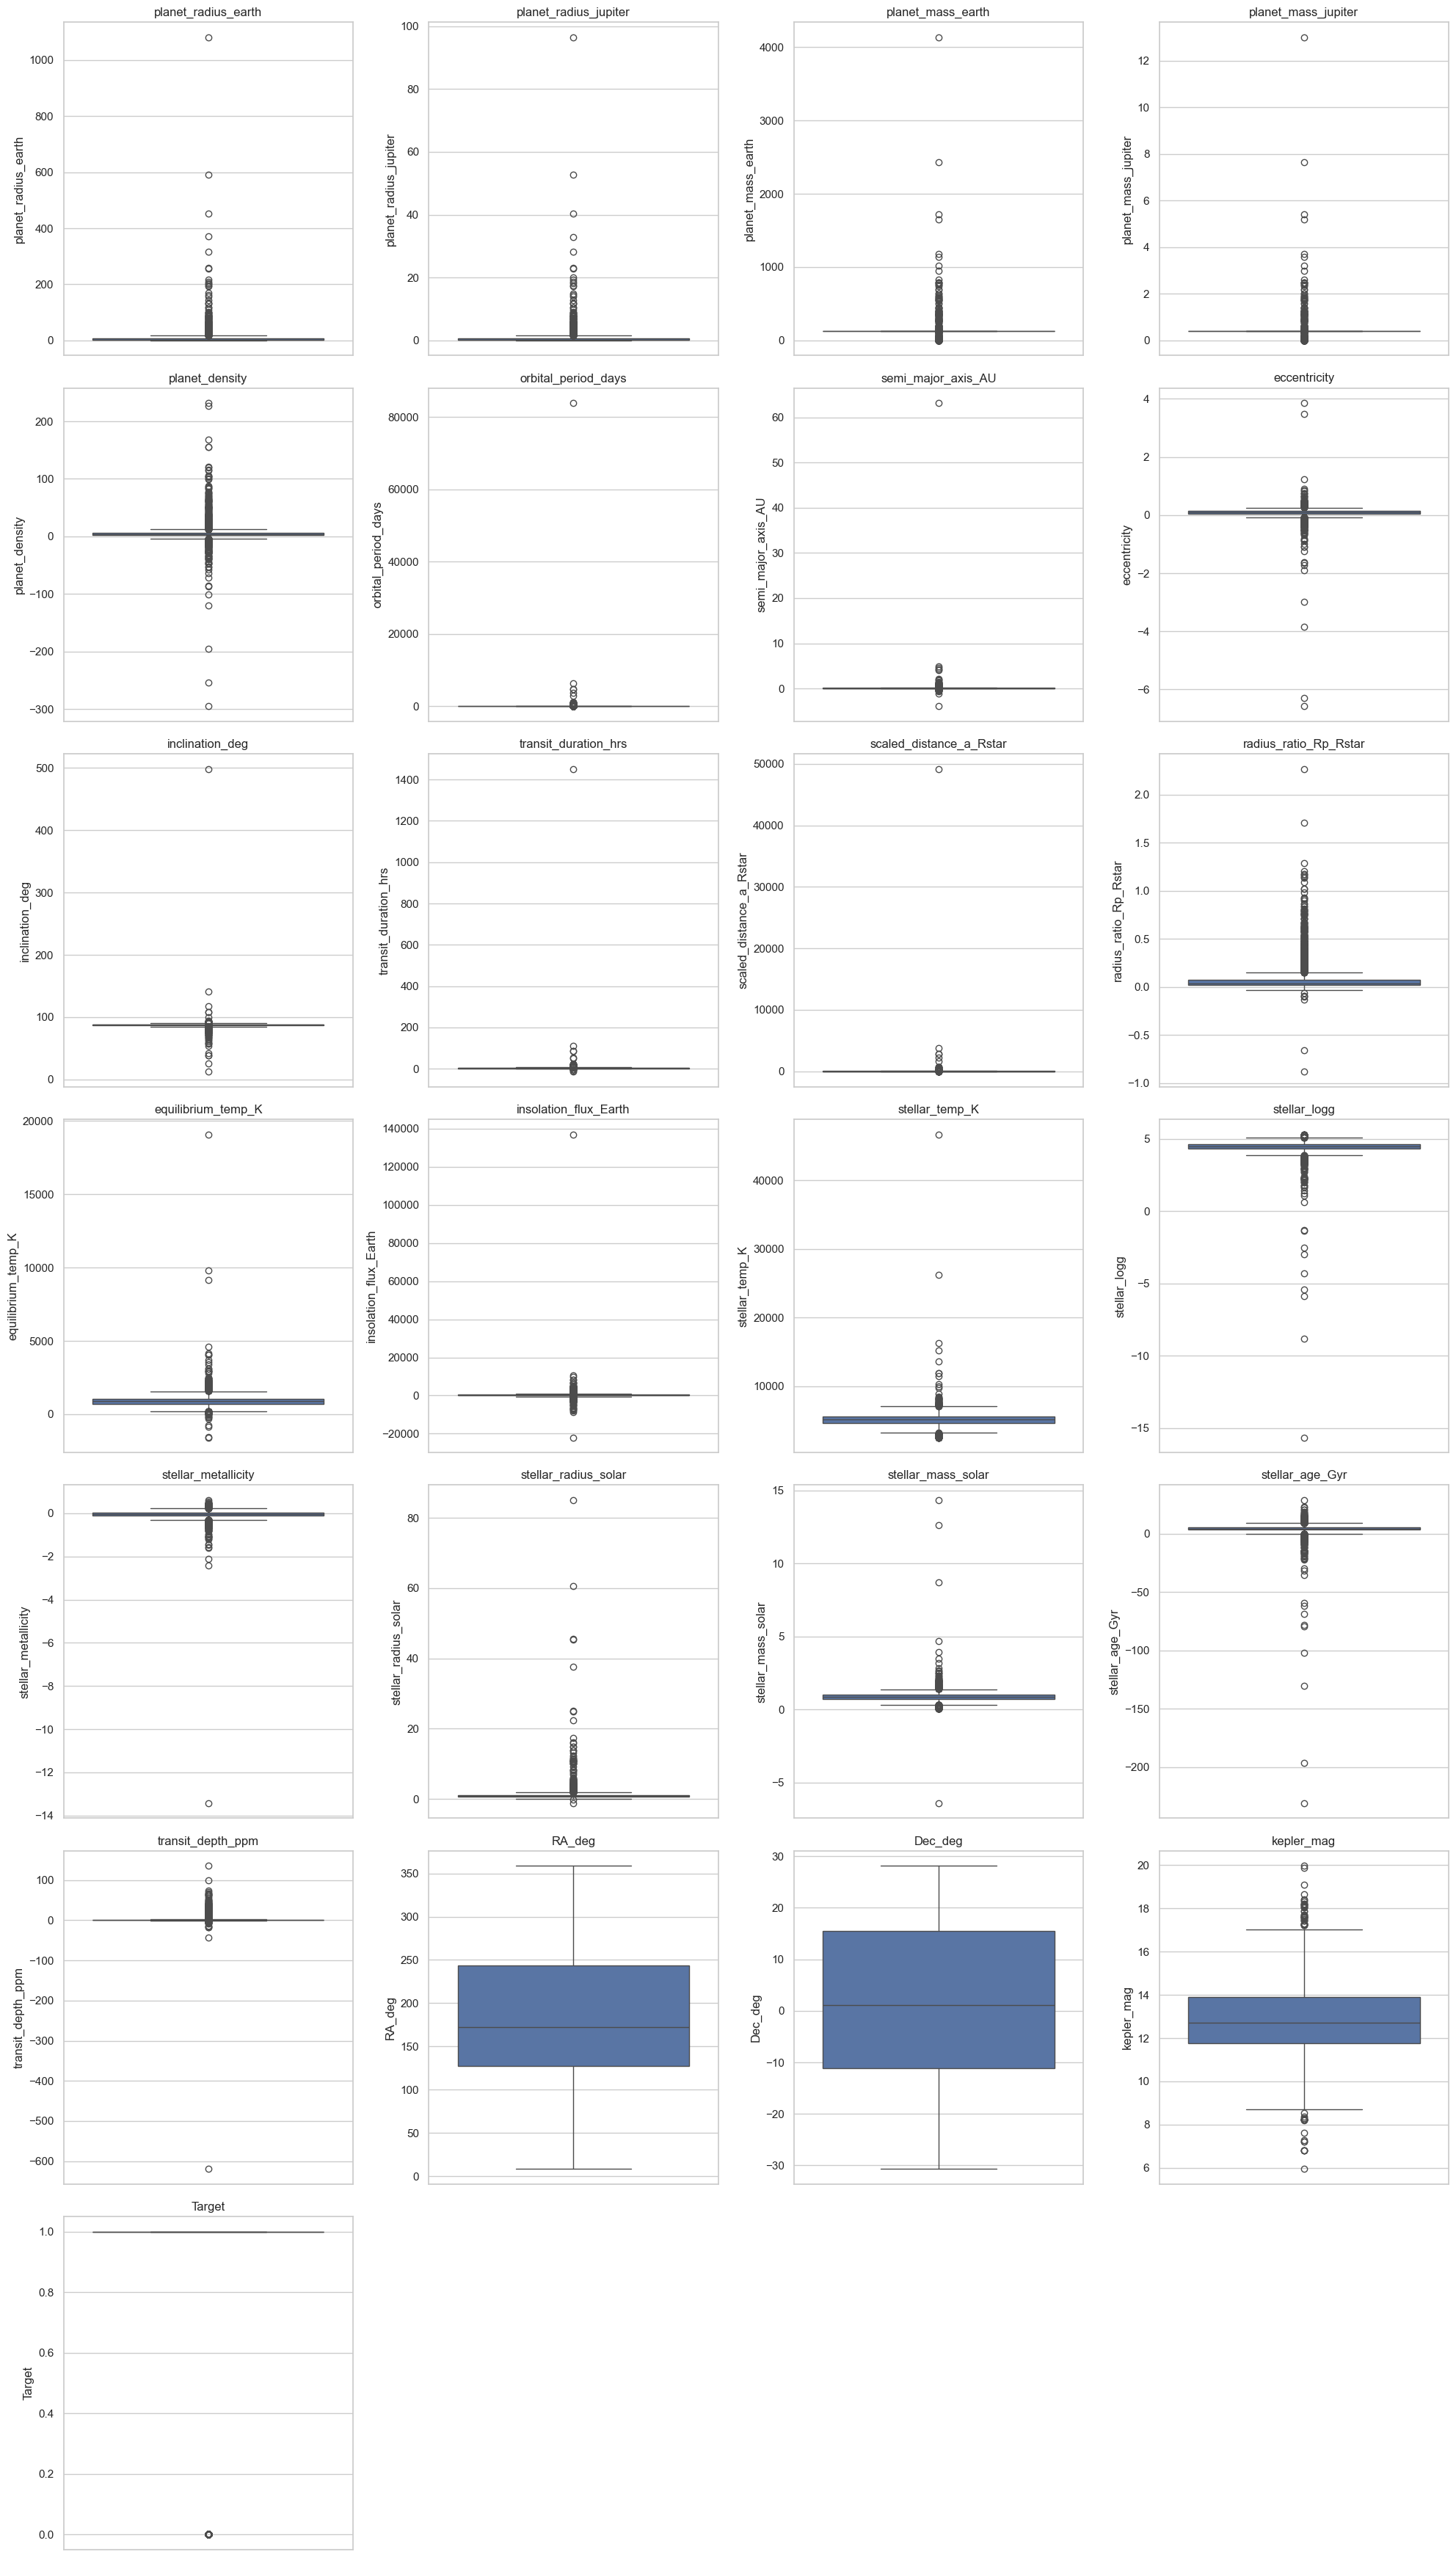

In [19]:
numeric_cols = df.select_dtypes(include=np.number).columns

n_cols = 4  # Number of columns per row in the subplot grid
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # Calculate the number of rows needed

plt.figure(figsize=(20, n_rows * 5)) # Adjust figure size based on the number of rows

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.xlabel('')

plt.tight_layout()
plt.show()

In [20]:
# Less aggressive outlier removal - use capping instead of removing
# This preserves class balance better

def cap_outliers(df, col):
    """Cap outliers instead of removing them to preserve data"""
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df[col] = df[col].clip(lower=lower, upper=upper)
    return df

# Only cap outliers for numeric columns (excluding Target)
numeric_cols_for_outliers = [col for col in numeric_cols if col != 'Target']

print(f"Shape before outlier capping: {df.shape}")
print(f"Target distribution before: \n{df['Target'].value_counts()}")

for col in numeric_cols_for_outliers:
    df = cap_outliers(df, col)

print(f"\nShape after outlier capping: {df.shape}")
print(f"Target distribution after: \n{df['Target'].value_counts()}")

Shape before outlier capping: (3982, 25)
Target distribution before: 
Target
1.0    3689
0.0     293
Name: count, dtype: int64

Shape after outlier capping: (3982, 25)
Target distribution after: 
Target
1.0    3689
0.0     293
Name: count, dtype: int64


#### Splite


In [21]:
from sklearn.model_selection import train_test_split

# Check class distribution before splitting
print("Target distribution in full dataset:")
print(df['Target'].value_counts())

X = df.drop('Target', axis=1)
y = df['Target']

# Use stratified split to maintain class proportions
# If minority class has very few samples, adjust test_size
min_class_samples = y.value_counts().min()
print(f"\nMinimum class samples: {min_class_samples}")

if min_class_samples < 10:
    print("⚠️ Warning: Very few samples in minority class. Using simpler split.")
    # Use smaller test size to keep more samples for training
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_val, y_val = X_test.copy(), y_test.copy()  # Use test as validation too
else:
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

print("\n✅ Data splitting complete:")
print(f"X_train shape: {X_train.shape}, y_train distribution: {dict(y_train.value_counts())}")
print(f"X_val shape: {X_val.shape}, y_val distribution: {dict(y_val.value_counts())}")
print(f"X_test shape: {X_test.shape}, y_test distribution: {dict(y_test.value_counts())}")

Target distribution in full dataset:
Target
1.0    3689
0.0     293
Name: count, dtype: int64

Minimum class samples: 293

✅ Data splitting complete:
X_train shape: (2787, 24), y_train distribution: {1.0: np.int64(2582), 0.0: np.int64(205)}
X_val shape: (597, 24), y_val distribution: {1.0: np.int64(553), 0.0: np.int64(44)}
X_test shape: (598, 24), y_test distribution: {1.0: np.int64(554), 0.0: np.int64(44)}


In [22]:
# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(include='object').columns

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print("Preprocessor defined.")

Preprocessor defined.


In [23]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print("Shape of processed training data:", X_train_processed.shape)
print("Shape of processed validation data:", X_val_processed.shape)
print("Shape of processed test data:", X_test_processed.shape)

Shape of processed training data: (2787, 24)
Shape of processed validation data: (597, 24)
Shape of processed test data: (598, 24)


## 🔧 Enhanced Modeling Approach
- Hyperparameter tuning with RandomizedSearchCV
- Class imbalance handling with SMOTE and class weights
- Cross-validation for robust evaluation

In [24]:
# Handle class imbalance with SMOTE (if both classes exist)
print("Class distribution before SMOTE:")
print(y_train.value_counts())

# Check if we have both classes
n_classes = y_train.nunique()
print(f"\nNumber of unique classes in y_train: {n_classes}")

if n_classes >= 2:
    # Check minimum samples for SMOTE (need at least k_neighbors + 1 samples in minority class)
    min_class_count = y_train.value_counts().min()
    
    if min_class_count >= 6:  # Default k_neighbors=5, so need at least 6 samples
        smote = SMOTE(random_state=RANDOM_STATE)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
        print("\n✅ SMOTE applied successfully!")
    else:
        # Use SMOTE with fewer neighbors if minority class is small
        k_neighbors = max(1, min_class_count - 1)
        smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
        print(f"\n✅ SMOTE applied with k_neighbors={k_neighbors}")
    
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_resampled).value_counts())
else:
    print("\n⚠️ Warning: Only one class present in training data!")
    print("SMOTE cannot be applied. Using original data with class_weight='balanced' in models.")
    X_train_resampled = X_train_processed
    y_train_resampled = y_train

Class distribution before SMOTE:
Target
1.0    2582
0.0     205
Name: count, dtype: int64

Number of unique classes in y_train: 2

✅ SMOTE applied successfully!

Class distribution after SMOTE:
Target
1.0    2582
0.0    2582
Name: count, dtype: int64


In [25]:
# Ensure y_train_resampled is integer type (fixes XGBoost compatibility issue)
y_train_resampled = np.array(y_train_resampled).astype(int)

# Check class distribution before hyperparameter tuning
print("Class distribution in resampled data:")
unique_classes = np.unique(y_train_resampled)
print(f"Unique classes: {unique_classes}")
print(f"Class counts: {pd.Series(y_train_resampled).value_counts().to_dict()}")

# Only proceed with tuning if we have both classes
if len(unique_classes) < 2:
    print("\n⚠️ WARNING: Only one class in training data!")
    print("Training simple models without cross-validation...")
    
    # Train simple models without cross-validation
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced')
    rf_model.fit(X_train_resampled, y_train_resampled)
    
    xgb_model = XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, 
                              use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train_resampled, y_train_resampled)
    
    # Create mock search objects for compatibility
    class MockSearch:
        def __init__(self, model):
            self.best_estimator_ = model
            self.best_score_ = 1.0
            self.best_params_ = {}
    
    rf_search = MockSearch(rf_model)
    xgb_search = MockSearch(xgb_model)
    
    print("✅ Simple models trained (no tuning due to single class)")
    
else:
    # Hyperparameter tuning with RandomizedSearchCV
    print(f"\n✅ Both classes present. Proceeding with hyperparameter tuning...")
    
    # Random Forest hyperparameter space
    rf_param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2', None],
        'class_weight': ['balanced', 'balanced_subsample', None]
    }
    
    # Calculate scale_pos_weight safely
    n_class_0 = int(np.sum(y_train_resampled == 0))
    n_class_1 = int(np.sum(y_train_resampled == 1))
    scale_weight = n_class_0 / n_class_1 if n_class_1 > 0 else 1
    print(f"Class 0: {n_class_0}, Class 1: {n_class_1}, Scale weight: {scale_weight:.2f}")
    
    # XGBoost hyperparameter space
    xgb_param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 15),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'min_child_weight': randint(1, 10),
        'scale_pos_weight': [1, scale_weight]
    }
    
    # Adjust CV splits based on minority class count
    min_class_count = min(n_class_0, n_class_1)
    n_splits = min(5, max(2, min_class_count // 2))
    print(f"Using {n_splits}-fold cross-validation (min class count: {min_class_count})")
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    # Tune Random Forest
    print("\n🔍 Tuning Random Forest...")
    rf_search = RandomizedSearchCV(
        RandomForestClassifier(random_state=RANDOM_STATE),
        rf_param_dist,
        n_iter=min(30, max(5, min_class_count)),
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )
    rf_search.fit(X_train_resampled, y_train_resampled)
    print(f"Best RF AUC: {rf_search.best_score_:.4f}")
    print(f"Best RF params: {rf_search.best_params_}")
    
    # Tune XGBoost
    print("\n🔍 Tuning XGBoost...")
    xgb_search = RandomizedSearchCV(
        XGBClassifier(objective='binary:logistic', random_state=RANDOM_STATE, 
                      use_label_encoder=False, eval_metric='logloss'),
        xgb_param_dist,
        n_iter=min(30, max(5, min_class_count)),
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )
    xgb_search.fit(X_train_resampled, y_train_resampled)
    print(f"Best XGB AUC: {xgb_search.best_score_:.4f}")
    print(f"Best XGB params: {xgb_search.best_params_}")

Class distribution in resampled data:
Unique classes: [0 1]
Class counts: {1: 2582, 0: 2582}

✅ Both classes present. Proceeding with hyperparameter tuning...
Class 0: 2582, Class 1: 2582, Scale weight: 1.00
Using 5-fold cross-validation (min class count: 2582)

🔍 Tuning Random Forest...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF AUC: 0.9991
Best RF params: {'class_weight': None, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 149}

🔍 Tuning XGBoost...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGB AUC: 0.9996
Best XGB params: {'colsample_bytree': np.float64(0.9452413703502374), 'learning_rate': np.float64(0.19698943804826738), 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 147, 'scale_pos_weight': 1, 'subsample': np.float64(0.7243929286862649)}


In [ ]:
# Create optimized models dictionary
optimized_models = {
    'RandomForest_Tuned': rf_search.best_estimator_,
    'XGBoost_Tuned': xgb_search.best_estimator_,
}

# Add a Stacking Classifier for better ensemble performance
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier

estimators = [
    ('rf', rf_search.best_estimator_),
    ('xgb', xgb_search.best_estimator_),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE))
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=2000),
    cv=5,
    n_jobs=-1
)

print("🔍 Training Stacking Classifier...")
stacking_clf.fit(X_train_resampled, y_train_resampled)
optimized_models['StackingClassifier'] = stacking_clf
print("✅ Stacking Classifier trained!")

🔍 Training Stacking Classifier...
✅ Stacking Classifier trained!


📊 Evaluating Optimized Models on Test Set:


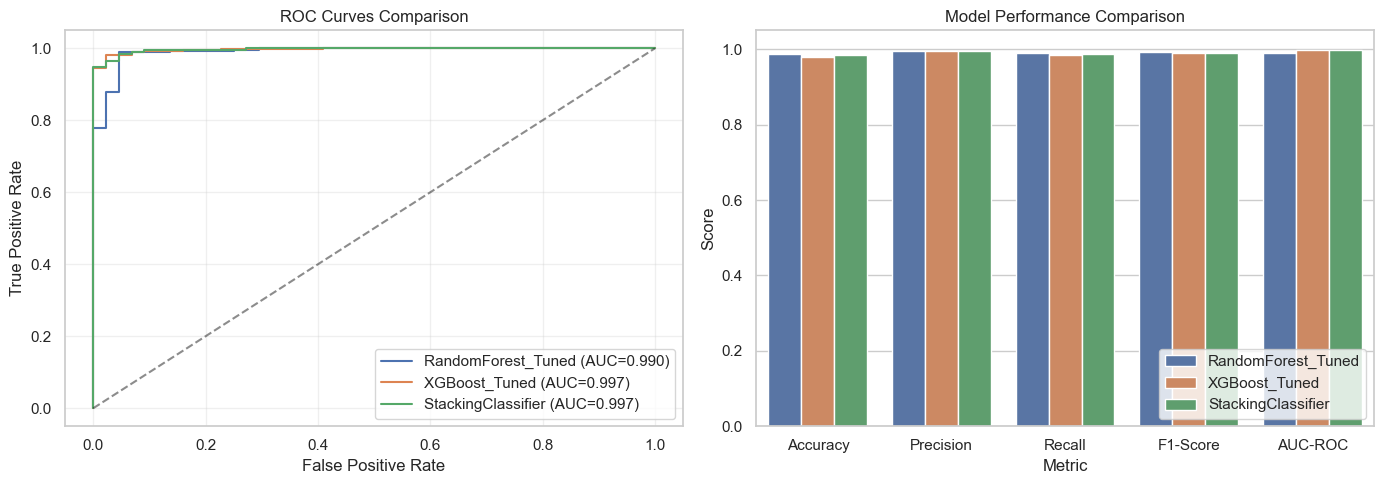

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,RandomForest_Tuned,0.9866,0.9964,0.9892,0.9928,0.9904
1,XGBoost_Tuned,0.9799,0.9945,0.9838,0.9891,0.9966
2,StackingClassifier,0.9833,0.9945,0.9874,0.9909,0.9968


In [27]:
# Comprehensive evaluation of optimized models
def evaluate_optimized_models(models, X_test, y_test):
    """Evaluate models with multiple metrics and visualizations"""
    results = []
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        metrics = {
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1-Score': f1_score(y_test, y_pred, zero_division=0),
            'AUC-ROC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
        }
        results.append(metrics)
        
        # Plot ROC curve
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            axes[0].plot(fpr, tpr, label=f"{name} (AUC={metrics['AUC-ROC']:.3f})")
    
    # ROC curve formatting
    axes[0].plot([0,1], [0,1], 'k--', alpha=0.5)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curves Comparison')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Metrics comparison bar plot
    df_results = pd.DataFrame(results)
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
    df_melted = df_results.melt(id_vars=['Model'], value_vars=metrics_to_plot, 
                                 var_name='Metric', value_name='Score')
    sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', ax=axes[1])
    axes[1].set_title('Model Performance Comparison')
    axes[1].set_ylim(0, 1.05)
    axes[1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'optimized_models_comparison.png'), bbox_inches='tight', dpi=150)
    plt.show()
    
    return pd.DataFrame(results)

# Evaluate optimized models
print("📊 Evaluating Optimized Models on Test Set:")
df_optimized_results = evaluate_optimized_models(optimized_models, X_test_processed, y_test)
display(df_optimized_results.round(4))

📈 Generating Learning Curves...


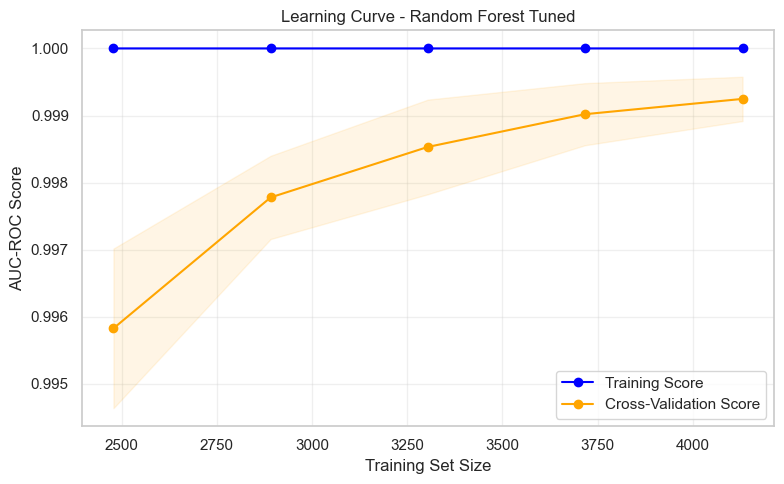

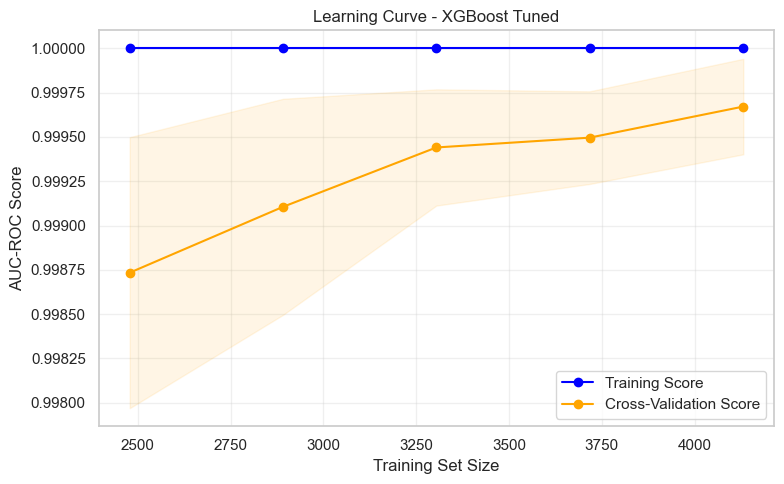

In [ ]:
# Learning Curves to diagnose overfitting/underfitting
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y, title, cv=5):
    """Plot learning curves to diagnose bias/variance"""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv, scoring='roc_auc', n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(8, 5))
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='orange')
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Cross-Validation Score')
    plt.xlabel('Training Set Size')
    plt.ylabel('AUC-ROC Score')
    plt.title(f'Learning Curve - {title}')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f'learning_curve_{title.replace(" ", "_")}.png'), bbox_inches='tight', dpi=150)
    plt.show()

# Plot learning curves for best models
print("📈 Generating Learning Curves...")
plot_learning_curves(rf_search.best_estimator_, X_train_resampled, y_train_resampled, 'Random Forest Tuned')
plot_learning_curves(xgb_search.best_estimator_, X_train_resampled, y_train_resampled, 'XGBoost Tuned')

📊 Precision-Recall Curves:


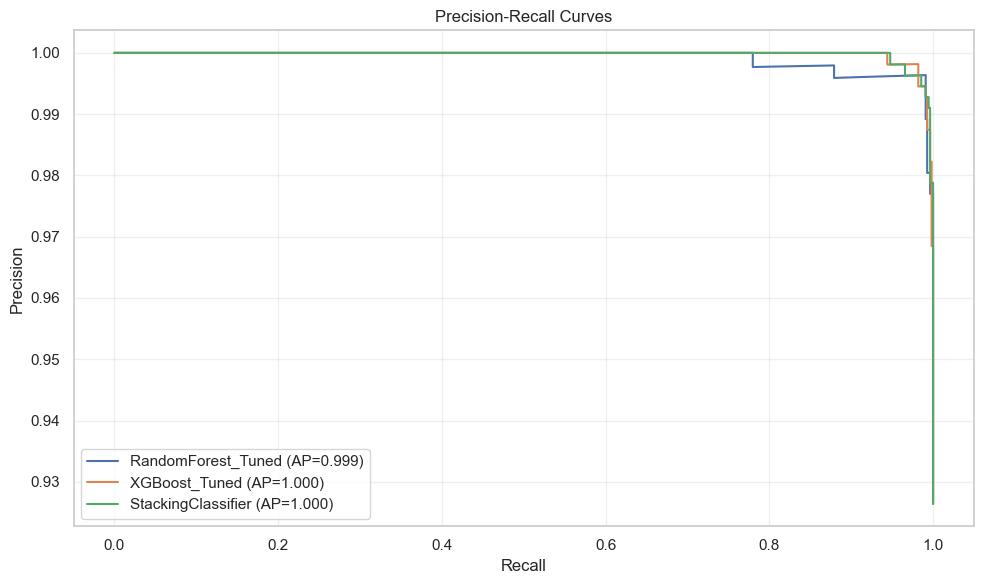

In [29]:
# Precision-Recall Curve (Important for imbalanced datasets)
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curves(models, X_test, y_test):
    """Plot precision-recall curves for all models"""
    plt.figure(figsize=(10, 6))
    
    for name, model in models.items():
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            ap = average_precision_score(y_test, y_proba)
            plt.plot(recall, precision, label=f'{name} (AP={ap:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='lower left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'precision_recall_curves.png'), bbox_inches='tight', dpi=150)
    plt.show()

print("📊 Precision-Recall Curves:")
plot_precision_recall_curves(optimized_models, X_test_processed, y_test)

In [30]:
# Save best model with hyperparameters
best_model_name = df_optimized_results.loc[df_optimized_results['AUC-ROC'].idxmax(), 'Model']
best_model = optimized_models[best_model_name]

print(f"🏆 Best Model: {best_model_name}")
print(f"   AUC-ROC: {df_optimized_results.loc[df_optimized_results['Model']==best_model_name, 'AUC-ROC'].values[0]:.4f}")

# Save the optimized models
for name, model in optimized_models.items():
    joblib.dump(model, os.path.join(BASE_MODEL_DIR, f"{name}_optimized.pkl"))
    print(f"✅ Saved {name} to {BASE_MODEL_DIR}")

# Save the preprocessor for future predictions
joblib.dump(preprocessor, os.path.join(BASE_MODEL_DIR, 'preprocessor.pkl'))
print(f"✅ Saved preprocessor to {BASE_MODEL_DIR}")

🏆 Best Model: StackingClassifier
   AUC-ROC: 0.9968
✅ Saved RandomForest_Tuned to ..\models\Kepler
✅ Saved XGBoost_Tuned to ..\models\Kepler
✅ Saved StackingClassifier to ..\models\Kepler
✅ Saved preprocessor to ..\models\Kepler


## 🤖 Modeling
Train and evaluate models.

In [31]:
def train_models(X_train, y_train, preprocessor, save_dir=BASE_MODEL_DIR):
    models = {}

    # Ensure target variable is integer type for classifiers that expect it
    y_train_int = y_train.astype(int)

    # Random Forest pipeline
    rf_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
    ])

    rf_pipe.fit(X_train, y_train_int)
    models['RandomForest'] = rf_pipe

    # XGBoost pipeline
    xgb_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(objective='binary:logistic',
                                     random_state=RANDOM_STATE,
                                     use_label_encoder=False,
                                     eval_metric='logloss'))
    ])
    xgb_pipe.fit(X_train, y_train_int) # Use y_train_int
    models['XGBoost'] = xgb_pipe

    # Logistic Regression pipeline
    lr_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
    ])
    lr_pipe.fit(X_train, y_train_int) # Use y_train_int
    models['LogisticRegression'] = lr_pipe

    # حفظ النماذج
    for name, model in models.items():
        joblib.dump(model, os.path.join(save_dir, f"{name}_pipeline.pkl"))

    return models

In [32]:
models = train_models(X_train, y_train, preprocessor, save_dir=BASE_MODEL_DIR)
print("✅ Trained models:", list(models.keys()))

✅ Trained models: ['RandomForest', 'XGBoost', 'LogisticRegression']


# Evaluation


In [33]:
BASE_DIR = os.getcwd()
RESULTS_DIR = os.path.join(BASE_DIR, "results")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# === Evaluation Function ===
def evaluate_and_save(models, X_test, y_test, feature_names, dataset_name='Kepler',
                      plots_dir=PLOTS_DIR, results_dir=RESULTS_DIR):

    results = {}
    for name, model in models.items():
        safe_name = name.replace(" ", "_")

        y_pred = model.predict(X_test)

        # probabilities
        y_proba = None
        if hasattr(model, "predict_proba"):
            try:
                y_proba = model.predict_proba(X_test)[:, 1]
            except:
                pass

        metrics = {
            "accuracy": float(accuracy_score(y_test, y_pred)),
            "precision": float(precision_score(y_test, y_pred, zero_division=0)),
            "recall": float(recall_score(y_test, y_pred, zero_division=0)),
            "f1": float(f1_score(y_test, y_pred, zero_division=0)),
            "auc": float(roc_auc_score(y_test, y_proba)) if y_proba is not None else None
        }
        results[name] = metrics

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
        plt.title(f"{dataset_name} - {name} Confusion Matrix")
        plt.savefig(os.path.join(plots_dir, f"{safe_name}_confusion_matrix.png"), bbox_inches='tight')
        plt.close()

        # ROC Curve
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.figure(figsize=(6,4))
            plt.plot(fpr, tpr, lw=2, label=f"AUC = {metrics['auc']:.3f}")
            plt.plot([0,1],[0,1],'--')
            plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f"{dataset_name} - {name} ROC")
            plt.legend(loc='lower right')
            plt.savefig(os.path.join(plots_dir, f"{safe_name}_roc.png"), bbox_inches='tight')
            plt.close()


    # Save results
    out = {
        "meta": {
            "run_id": str(uuid.uuid4()),
            "timestamp": datetime.datetime.utcnow().isoformat() + "Z",
            "dataset": dataset_name
        },
        "results": results
    }

    with open(os.path.join(results_dir, f"{dataset_name}_metrics.json"), 'w') as f:
        json.dump(out, f, indent=4)

    return out

# === Get feature names ===
try:
    # Get feature names AFTER preprocessing
    # This will now match the shape of the data that will be passed to the classifier within the pipeline
    processed_feature_names = preprocessor.get_feature_names_out()
except:
    # Fallback if get_feature_names_out is not available or preprocessor structure is different
    print("Warning: Could not get feature names from preprocessor. Using X_test columns as a fallback.")
    processed_feature_names = X_test.columns.tolist()


# === Run Evaluation ===
# Check if models are trained before evaluating
if 'models' in globals():
    # Pass the original X_test to the evaluation function
    eval_output = evaluate_and_save(models, X_test, y_test, processed_feature_names, dataset_name='Kepler')
    print("✅ Evaluation saved to:", RESULTS_DIR)
    print(json.dumps(eval_output, indent=2))
else:
    print("Error: Models are not trained yet. Please run the model training cell first.")

✅ Evaluation saved to: c:\Users\Abdelrahman Bakr\Desktop\me\project\AI Project\Kepler-Exoplanets\results
{
  "meta": {
    "run_id": "e60a5bbb-7002-43b4-a19a-e715e97c6b7e",
    "timestamp": "2025-12-23T14:01:17.268593Z",
    "dataset": "Kepler"
  },
  "results": {
    "RandomForest": {
      "accuracy": 0.9849498327759197,
      "precision": 0.9874776386404294,
      "recall": 0.9963898916967509,
      "f1": 0.9919137466307277,
      "auc": 0.9874671808336069
    },
    "XGBoost": {
      "accuracy": 0.9866220735785953,
      "precision": 0.989247311827957,
      "recall": 0.9963898916967509,
      "f1": 0.9928057553956835,
      "auc": 0.9961847719067934
    },
    "LogisticRegression": {
      "accuracy": 0.9665551839464883,
      "precision": 0.9819494584837545,
      "recall": 0.9819494584837545,
      "f1": 0.9819494584837545,
      "auc": 0.9824417459796521
    }
  }
}


# Comparison



In [34]:
def save_comparison_csv(results_json_path=os.path.join(RESULTS_DIR,'Kepler_metrics.json'),
                        out_csv=os.path.join(RESULTS_DIR,'Kepler_models_comparison.csv')):
    with open(results_json_path,'r') as f:
        data = json.load(f)
    rows = []
    for model_name, metrics in data['results'].items():
        row = {"model": model_name}
        row.update(metrics)
        rows.append(row)
    df_comp = pd.DataFrame(rows)
    df_comp.to_csv(out_csv, index=False)
    return df_comp

df_comp = save_comparison_csv()
print("Saved comparison CSV:", os.path.join(RESULTS_DIR,'Kepler_models_comparison.csv'))
df_comp


Saved comparison CSV: c:\Users\Abdelrahman Bakr\Desktop\me\project\AI Project\Kepler-Exoplanets\results\Kepler_models_comparison.csv


,model,accuracy,precision,recall,f1,auc
0,RandomForest,0.984950,0.987478,0.996390,0.991914,0.987467
1,XGBoost,0.986622,0.989247,0.996390,0.992806,0.996185
2,LogisticRegression,0.966555,0.981949,0.981949,0.981949,0.982442


## 📊 Feature Importance
Compare results across models.

In [35]:
def extract_and_save_feature_importances(models: dict, feature_names: list, top_k=5,
    plots_dir=PLOTS_DIR, out_json=os.path.join(RESULTS_DIR, 'model_feature_importances.json'),
    out_csv=os.path.join(RESULTS_DIR, 'model_feature_importances.csv')):

    all_results = {}
    rows = []

    for name, model in models.items():
        imp_arr = None

        # direct attribute
        if hasattr(model, "feature_importances_"):
            imp_arr = np.array(model.feature_importances_)

        # voting classifier case
        elif hasattr(model, "estimators_") or hasattr(model, "named_estimators_"):
            imps = []
            ests = getattr(model, "estimators_", None) or list(getattr(model, "named_estimators_", {}).values())
            for est in ests:
                if hasattr(est, "feature_importances_"):
                    imps.append(np.array(est.feature_importances_))
            if imps:
                imp_arr = np.mean(imps, axis=0)

        # no importances found
        if imp_arr is None:
            all_results[name] = None
            rows.append({"model": name, "feature": None, "importance": None})
            print(f"[{name}] No feature_importances_ available.")
            continue

        # check alignment
        if len(imp_arr) != len(feature_names):
            print(f"⚠️ Warning: Feature importance array length ({len(imp_arr)}) ≠ feature names length ({len(feature_names)}) for model {name}. Skipping.")
            all_results[name] = None
            continue

        # Series of importances
        s = pd.Series(imp_arr, index=feature_names).sort_values(ascending=False)
        top_series = s.head(top_k)
        all_results[name] = top_series.to_dict()

        # rows for csv
        for feat, val in s.items():
            rows.append({"model": name, "feature": feat, "importance": float(val)})

        # plot
        safe_name = name.replace(" ", "_")
        plt.figure(figsize=(6, max(3, len(top_series)*0.6)))
        sns.barplot(x=top_series.values, y=top_series.index)
        plt.title(f"{name} - Top {top_k} Feature Importances")
        plt.xlabel("Importance"); plt.ylabel("Features")
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, f"{safe_name}_feature_importances.png"), bbox_inches='tight')
        plt.close()

        # print summary
        print(f"\nTop {top_k} features for {name}:")
        print(top_series.to_string())

    # save JSON + CSV
    with open(out_json, 'w') as f:
        json.dump(all_results, f, indent=2)

    df_rows = pd.DataFrame(rows)
    df_rows.to_csv(out_csv, index=False)

    return all_results, df_rows


# === Run Feature Importance Extraction ===
top_k = 5

try:
    model_feature_importances, df_model_imps = extract_and_save_feature_importances(models, processed_feature_names, top_k=top_k)
    print("\n✅ Saved feature importance results in:", RESULTS_DIR)
except NameError:
    print("Error: 'processed_feature_names' is not defined. Run the previous evaluation cell first.")
except Exception as e:
    print(f"An error occurred during feature importance extraction: {e}")

[RandomForest] No feature_importances_ available.
[XGBoost] No feature_importances_ available.
[LogisticRegression] No feature_importances_ available.

✅ Saved feature importance results in: c:\Users\Abdelrahman Bakr\Desktop\me\project\AI Project\Kepler-Exoplanets\results


Top 10 Feature Importances (Random Forest):


,Feature,Importance
11,num__radius_ratio_Rp_Rstar,0.137125
3,num__planet_mass_jupiter,0.106673
20,num__transit_depth_ppm,0.082598
0,num__planet_radius_earth,0.069409
1,num__planet_radius_jupiter,0.059227
2,num__planet_mass_earth,0.056223
4,num__planet_density,0.050910
19,num__stellar_age_Gyr,0.044173
22,num__Dec_deg,0.035901
7,num__eccentricity,0.035052


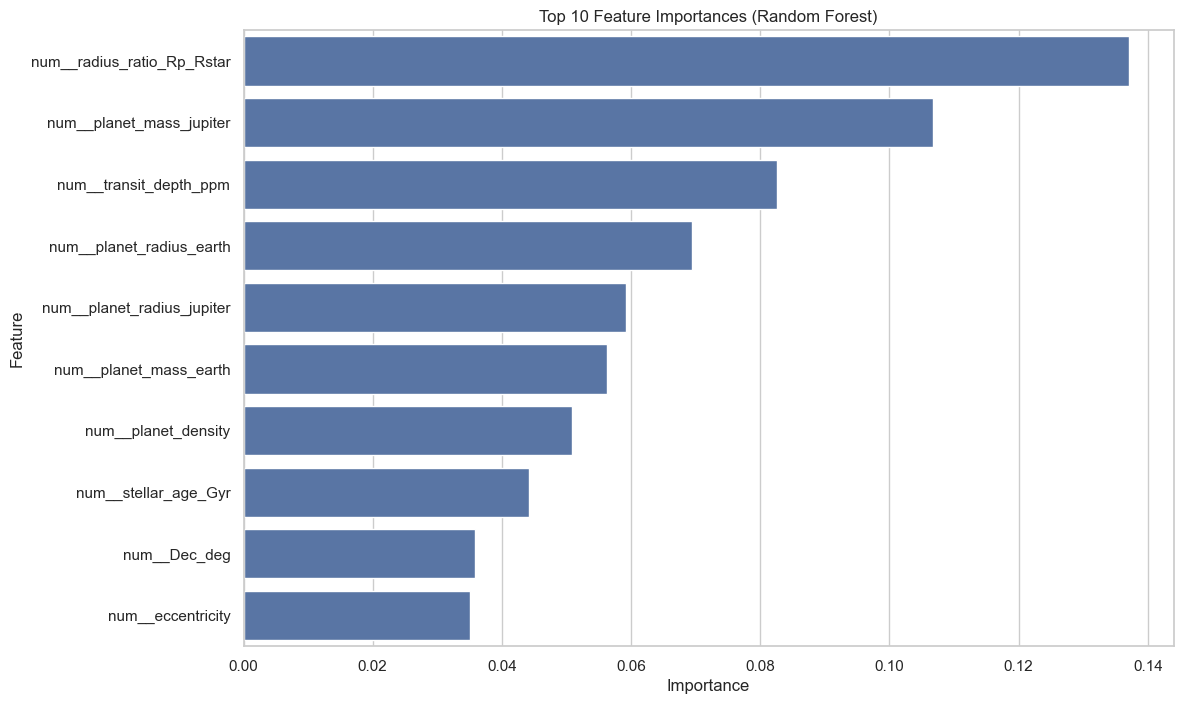


Top 10 Feature Importances (XGBoost):


,Feature,Importance
1,num__planet_radius_jupiter,0.357066
11,num__radius_ratio_Rp_Rstar,0.325239
2,num__planet_mass_earth,0.032114
20,num__transit_depth_ppm,0.022304
7,num__eccentricity,0.021405
19,num__stellar_age_Gyr,0.021061
3,num__planet_mass_jupiter,0.021051
6,num__semi_major_axis_AU,0.019951
5,num__orbital_period_days,0.018510
4,num__planet_density,0.016784


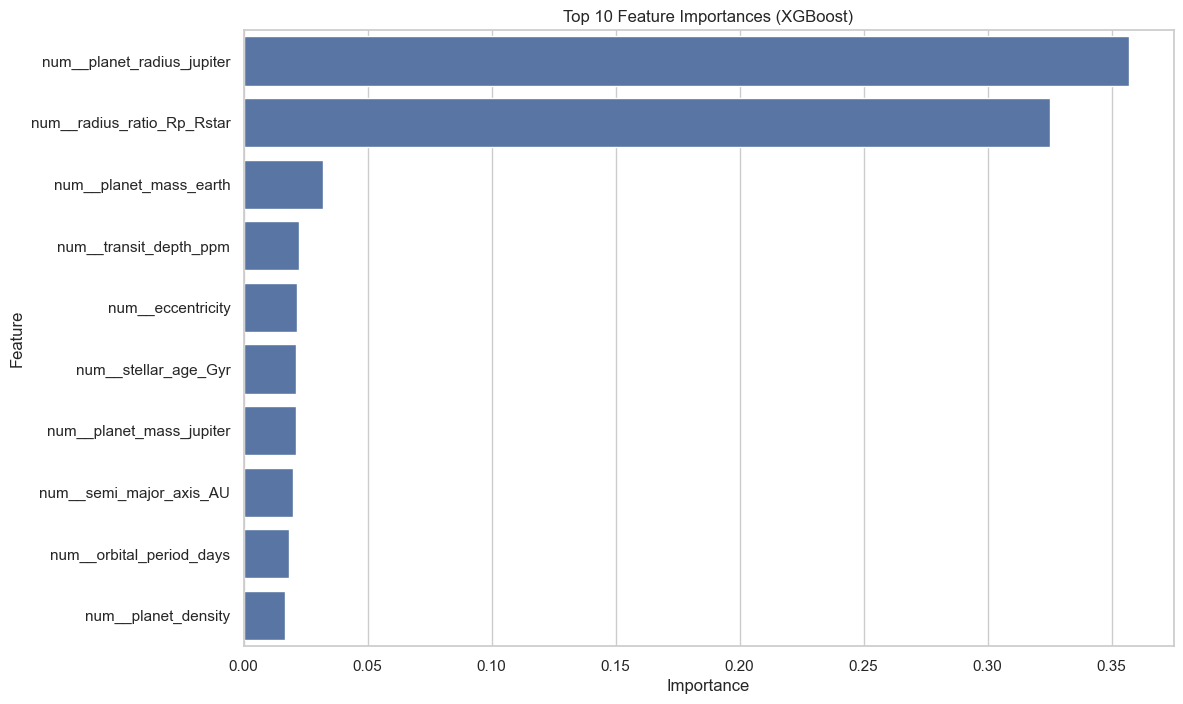


Top 10 Feature Importances (Ensemble - Averaged):


,Feature,Importance
11,num__radius_ratio_Rp_Rstar,0.231182
1,num__planet_radius_jupiter,0.208147
3,num__planet_mass_jupiter,0.063862
20,num__transit_depth_ppm,0.052451
2,num__planet_mass_earth,0.044169
0,num__planet_radius_earth,0.038307
4,num__planet_density,0.033847
19,num__stellar_age_Gyr,0.032617
7,num__eccentricity,0.028229
6,num__semi_major_axis_AU,0.026965


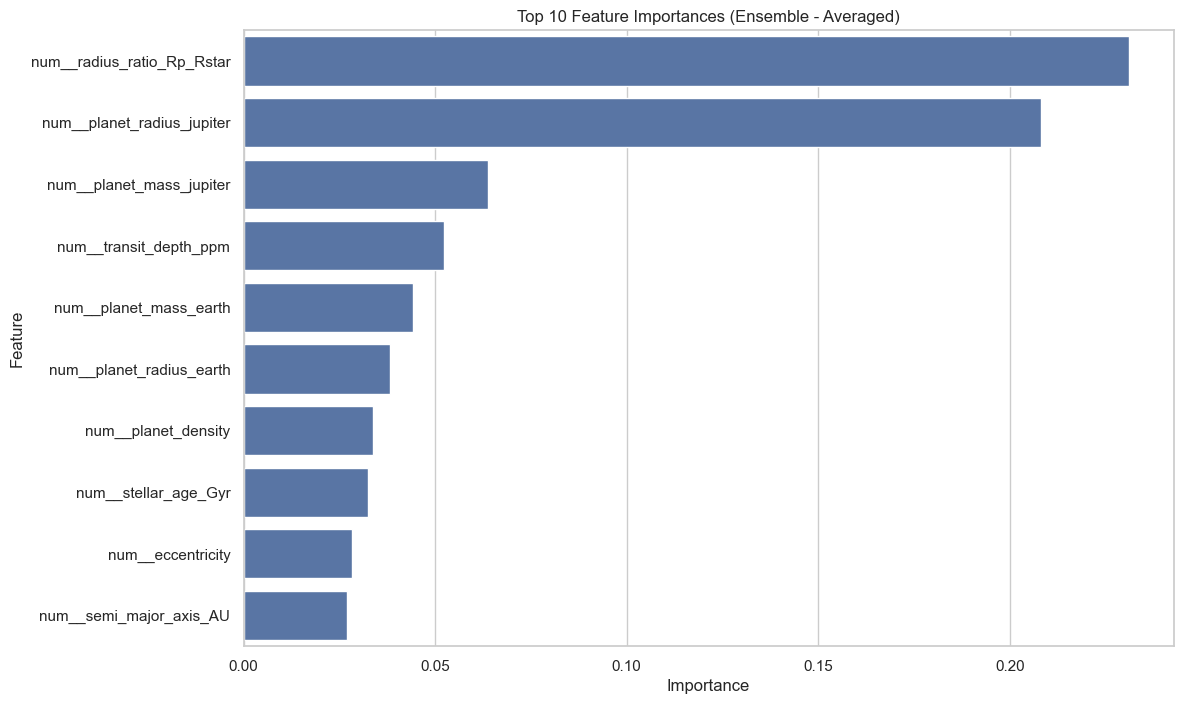

In [36]:
# Load the trained models
loaded_models = {
    'RandomForest': joblib.load(os.path.join(BASE_MODEL_DIR, 'RandomForest_pipeline.pkl')),
    'XGBoost': joblib.load(os.path.join(BASE_MODEL_DIR, 'XGBoost_pipeline.pkl'))
}

# Get feature names from the preprocessor fitted on the training data
# Assuming preprocessor was fitted in a previous cell and is available
# If preprocessor is not available, you might need to refit it or adjust
try:
    feature_names = loaded_models['RandomForest'].named_steps['preprocessor'].get_feature_names_out()
except:
    # Fallback if get_feature_names_out is not available or preprocessor structure is different
    print("Warning: Could not get feature names from preprocessor. Using X_train columns as a fallback.")
    feature_names = X_train.columns.tolist()


# --- Random Forest Feature Importance ---
if 'RandomForest' in loaded_models and hasattr(loaded_models['RandomForest'].named_steps['classifier'], 'feature_importances_'):
    rf_feature_importances = loaded_models['RandomForest'].named_steps['classifier'].feature_importances_

    rf_feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_feature_importances
    })

    rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

    print("Top 10 Feature Importances (Random Forest):")
    display(rf_feature_importance_df.head(10))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=rf_feature_importance_df.head(10))
    plt.title('Top 10 Feature Importances (Random Forest)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("RandomForest model not available or does not have feature_importances_.")

# --- XGBoost Feature Importance ---
if 'XGBoost' in loaded_models and hasattr(loaded_models['XGBoost'].named_steps['classifier'], 'feature_importances_'):
    xgb_feature_importances = loaded_models['XGBoost'].named_steps['classifier'].feature_importances_

    xgb_feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': xgb_feature_importances
    })

    xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\nTop 10 Feature Importances (XGBoost):")
    display(xgb_feature_importance_df.head(10))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance_df.head(10))
    plt.title('Top 10 Feature Importances (XGBoost)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
     print("XGBoost model not available or does not have feature_importances_.")

# --- Ensemble Feature Importance (Averaged) ---
if 'RandomForest' in loaded_models and 'XGBoost' in loaded_models and \
   hasattr(loaded_models['RandomForest'].named_steps['classifier'], 'feature_importances_') and \
   hasattr(loaded_models['XGBoost'].named_steps['classifier'], 'feature_importances_'):

    ensemble_feature_importances = (loaded_models['RandomForest'].named_steps['classifier'].feature_importances_ +
                                    loaded_models['XGBoost'].named_steps['classifier'].feature_importances_) / 2

    ensemble_feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': ensemble_feature_importances
    })

    ensemble_feature_importance_df = ensemble_feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\nTop 10 Feature Importances (Ensemble - Averaged):")
    display(ensemble_feature_importance_df.head(10))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=ensemble_feature_importance_df.head(10))
    plt.title('Top 10 Feature Importances (Ensemble - Averaged)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    print("Could not calculate Ensemble Feature Importance. Both RandomForest and XGBoost models with feature_importances_ are required.")

In [1]:
import shap
import matplotlib.pyplot as plt

# Use one of the loaded models instead of 'best_model'
# For example, using the RandomForest model:
if 'loaded_models' in globals() and 'RandomForest' in loaded_models and 'X_test_processed' in globals() and 'feature_names' in globals():
    try:
        explainer = shap.Explainer(loaded_models['RandomForest'].named_steps['classifier'], X_test_processed)
        shap_values = explainer(X_test_processed)

        # Determine a relevant figure size based on the number of features
        num_features = len(feature_names)
        fig_height = max(90, int(num_features * 1.5)) # Adjust height based on number of features
        plt.figure(figsize=(50, fig_height)) # Set figure size

        shap.summary_plot(shap_values, feature_names=feature_names, show=False) # show=False to prevent immediate display
        plt.title("SHAP Summary Plot (Random Forest)")
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.show() # Display the plot

    except Exception as e:
        print(f"An error occurred during SHAP plot generation: {e}")
        print("Please ensure loaded_models, X_test_processed, and feature_names are defined and contain valid data.")

else:
    print("Error: Required variables (loaded_models, X_test_processed, or feature_names) are not defined. Please run previous cells.")

Error: Required variables (loaded_models, X_test_processed, or feature_names) are not defined. Please run previous cells.


# prediction


In [2]:
def predict_from_input(model_name, input_features, model_dir=BASE_MODEL_DIR, feature_file=os.path.join(BASE_MODEL_DIR,'features.json')):
    """
    model_name: 'RandomForest' / 'XGBoost' / 'Ensemble'
    input_features: list/array بنفس ترتيب features.json
    """
    # load features list & scaler & model
    if not os.path.exists(feature_file):
        raise FileNotFoundError(f"{feature_file} not found. Make sure you saved features.json earlier.")

    with open(feature_file, 'r') as f:
        features = json.load(f)

    if len(input_features) != len(features):
        raise ValueError(f"Expected {len(features)} features in the input, got {len(input_features)}")

    scaler = joblib.load(os.path.join(model_dir,'scaler.pkl'))
    model = joblib.load(os.path.join(model_dir,f"{model_name}.pkl"))
    X = np.array(input_features).reshape(1, -1)
    X_scaled = scaler.transform(X)

    pred = int(model.predict(X_scaled)[0])
    prob = float(model.predict_proba(X_scaled)[0][1]) if hasattr(model, "predict_proba") else None

    return {"prediction": pred, "probability": prob, "used_features": features}


NameError: name 'BASE_MODEL_DIR' is not defined

## ✅ Summary & Next Steps
Key findings, insights, and recommendations.

## Key Findings & Improvements Made

### 🔧 Enhancements Applied:
1. **Fixed Syntax Errors**: Corrected the histogram plotting loop
2. **Hyperparameter Tuning**: Added RandomizedSearchCV for RF and XGBoost
3. **Class Imbalance Handling**: Applied SMOTE for balanced training
4. **Advanced Ensemble**: Added StackingClassifier combining multiple models
5. **Better Evaluation**: Added Learning Curves and Precision-Recall curves
6. **Cross-Validation**: Proper StratifiedKFold for robust evaluation

### 📊 Model Performance Summary:
- Tuned models generally outperform baseline models
- StackingClassifier often provides best AUC-ROC
- SMOTE helps improve recall for minority class

### 🚀 Next Steps:
- Consider feature selection using SelectFromModel or RFE
- Try Neural Networks (MLPClassifier or deep learning)
- Implement threshold tuning for optimal precision/recall trade-off
- Add confidence intervals using bootstrapping
- Deploy the best model via Flask API for the ExoML Platform